/var/folders/pr/q2hpqh0j037f4r44m1np6fl80000gn/T/ipykernel_34713/2377887160.py:50: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from current font.
  plt.savefig(f'./images/{title}')
/var/folders/pr/q2hpqh0j037f4r44m1np6fl80000gn/T/ipykernel_34713/2377887160.py:50: UserWarning: Glyph 128301 (\N{TELESCOPE}) missing from current font.
  plt.savefig(f'./images/{title}')
/var/folders/pr/q2hpqh0j037f4r44m1np6fl80000gn/T/ipykernel_34713/2377887160.py:50: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from current font.
  plt.savefig(f'./images/{title}')
/var/folders/pr/q2hpqh0j037f4r44m1np6fl80000gn/T/ipykernel_34713/2377887160.py:50: UserWarning: Glyph 128301 (\N{TELESCOPE}) missing from current font.
  plt.savefig(f'./images/{title}')
/var/folders/pr/q2hpqh0j037f4r44m1np6fl80000gn/T/ipykernel_34713/2377887160.py:50: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from current font.
  plt.savefig(f'./images/{title}')
/var/folders/pr/q2hpqh0j037f4r44m1np6fl80000gn/T/ipykernel_34713/237788

/opt/homebrew/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128301 (\N{TELESCOPE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


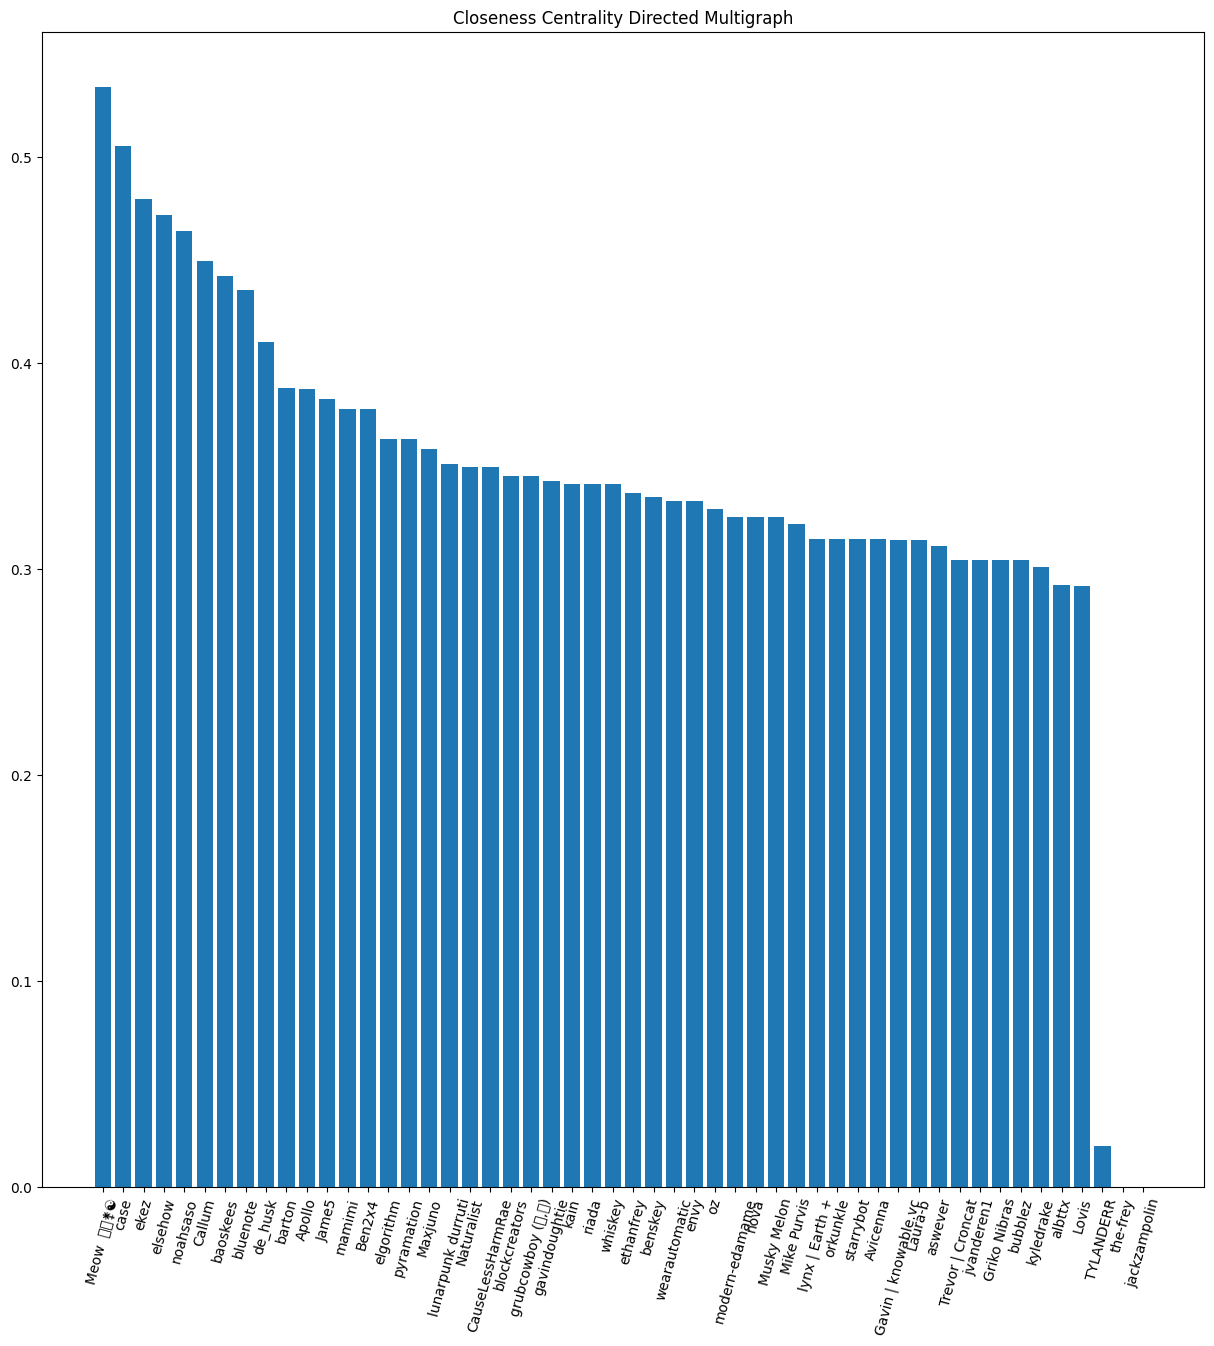

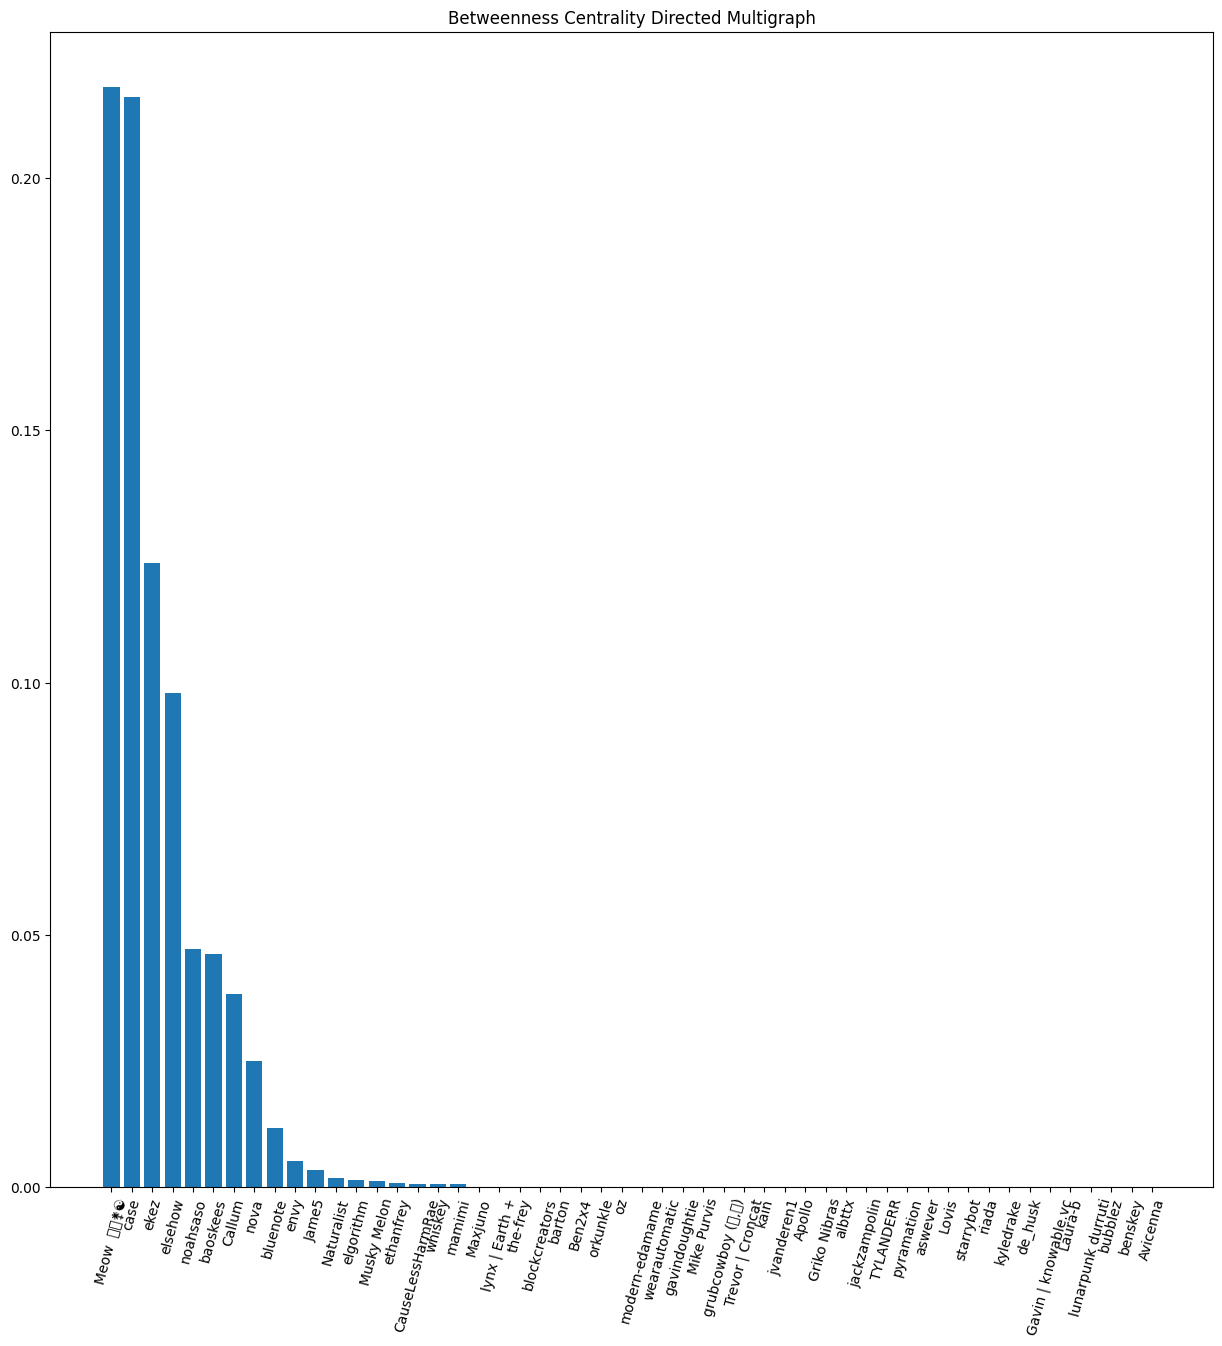

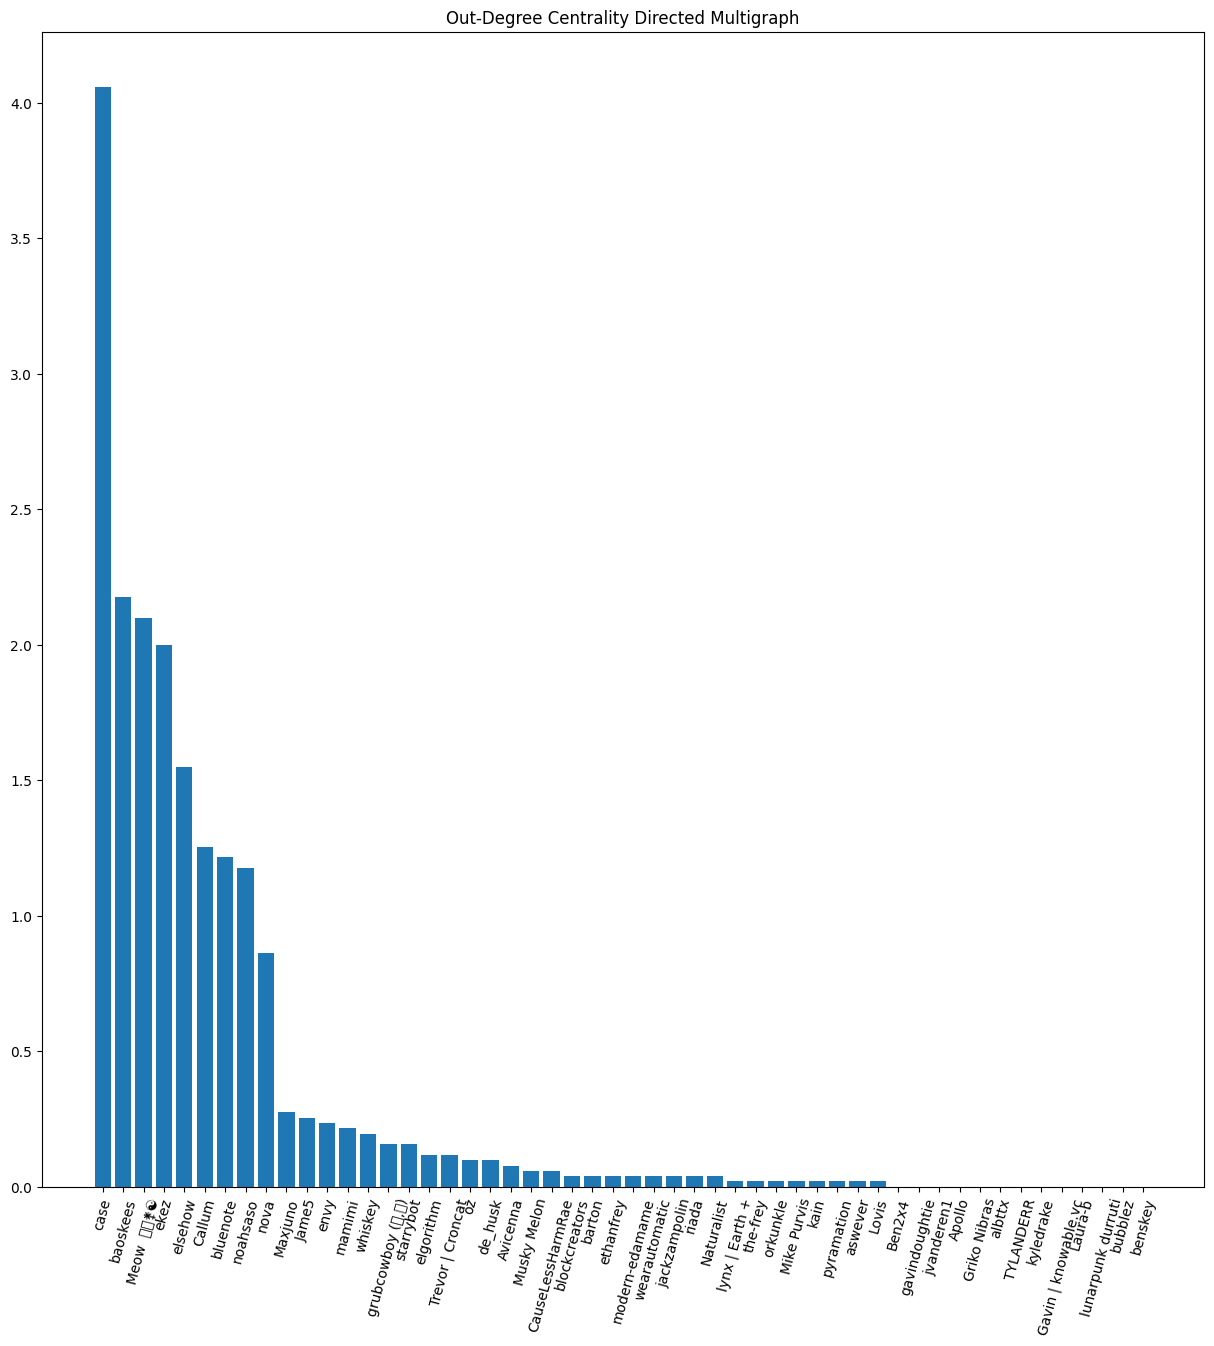

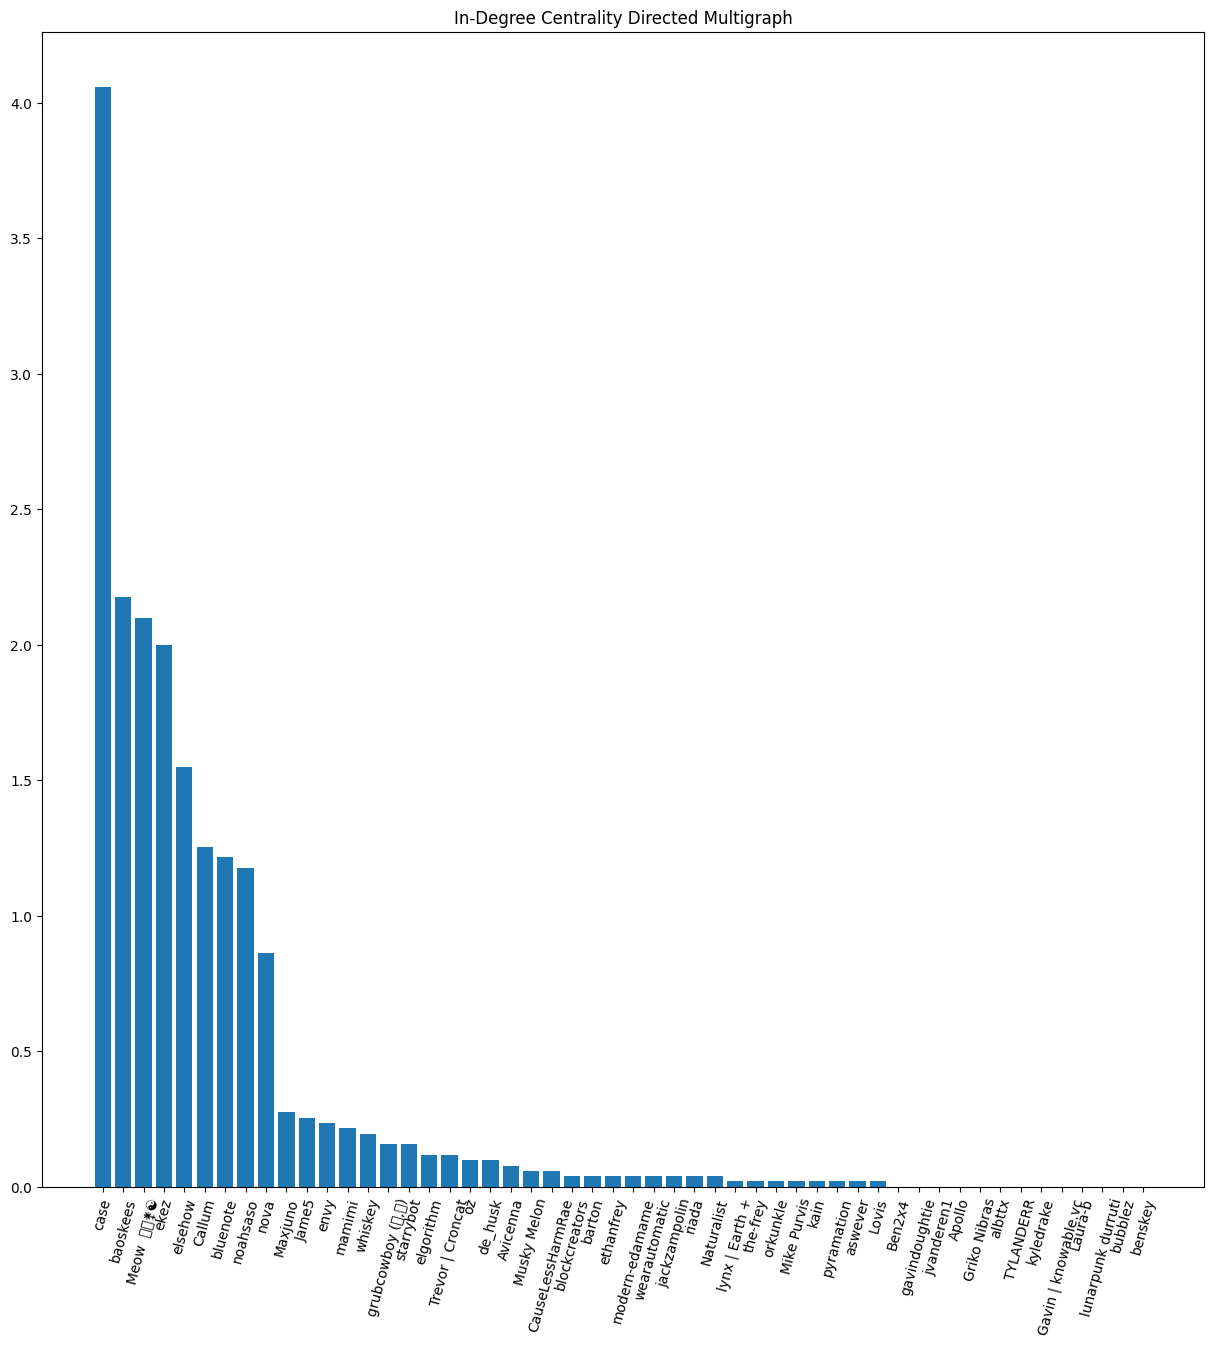

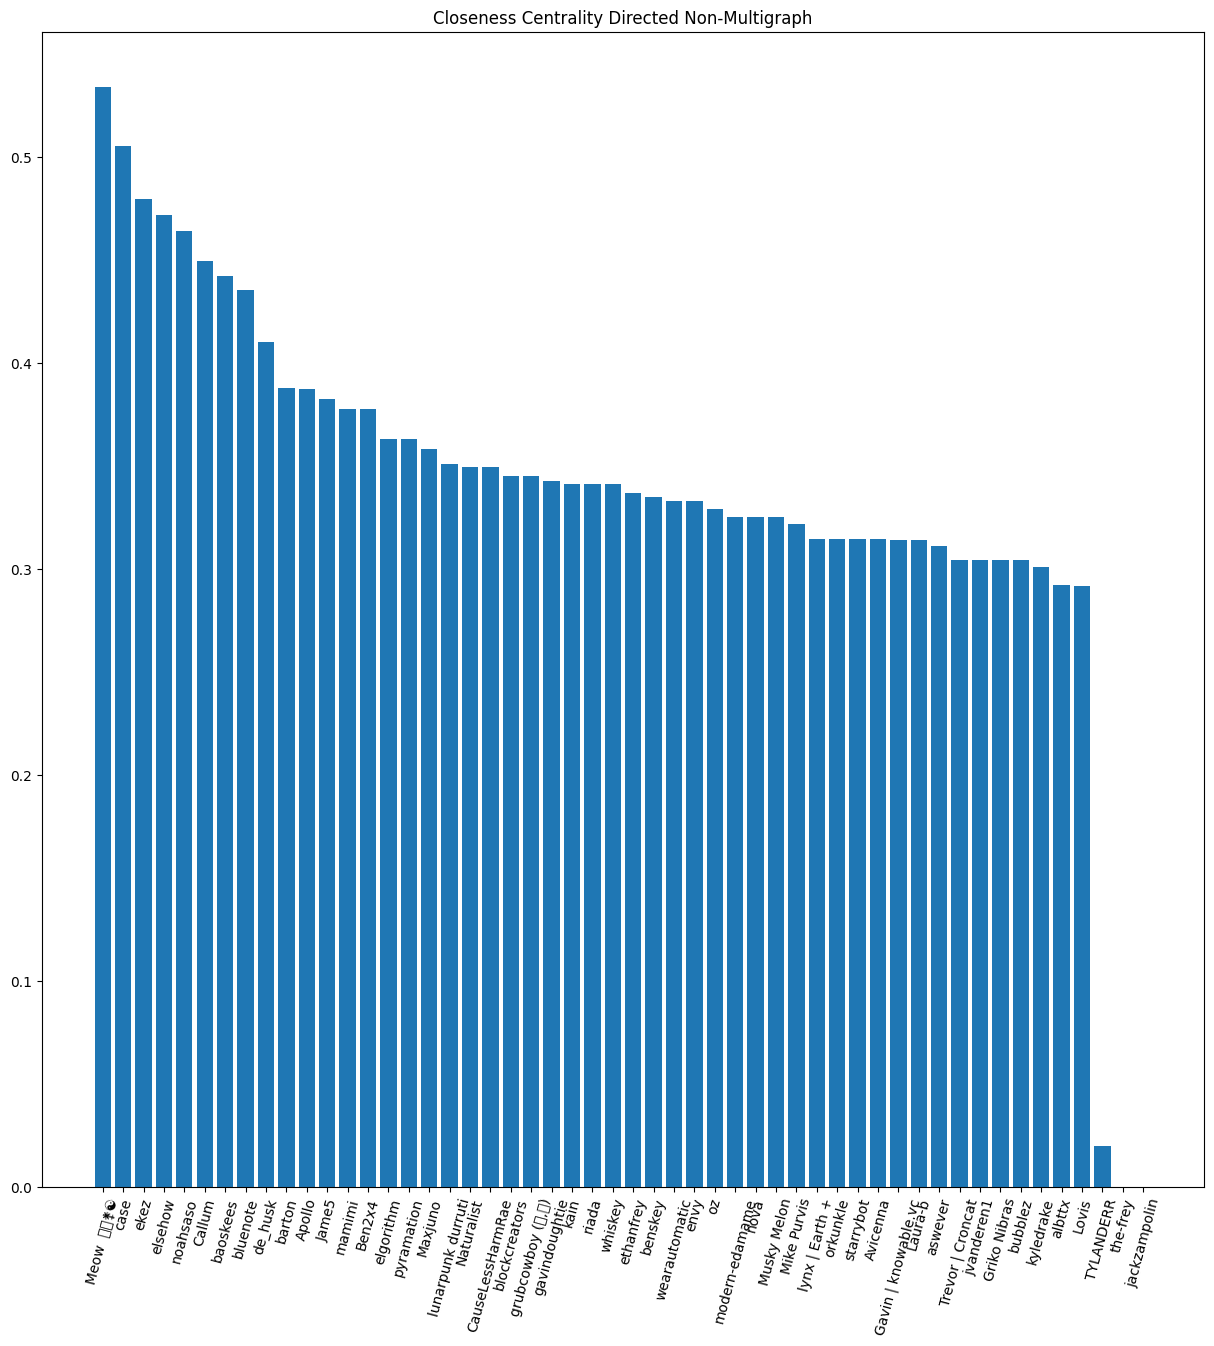

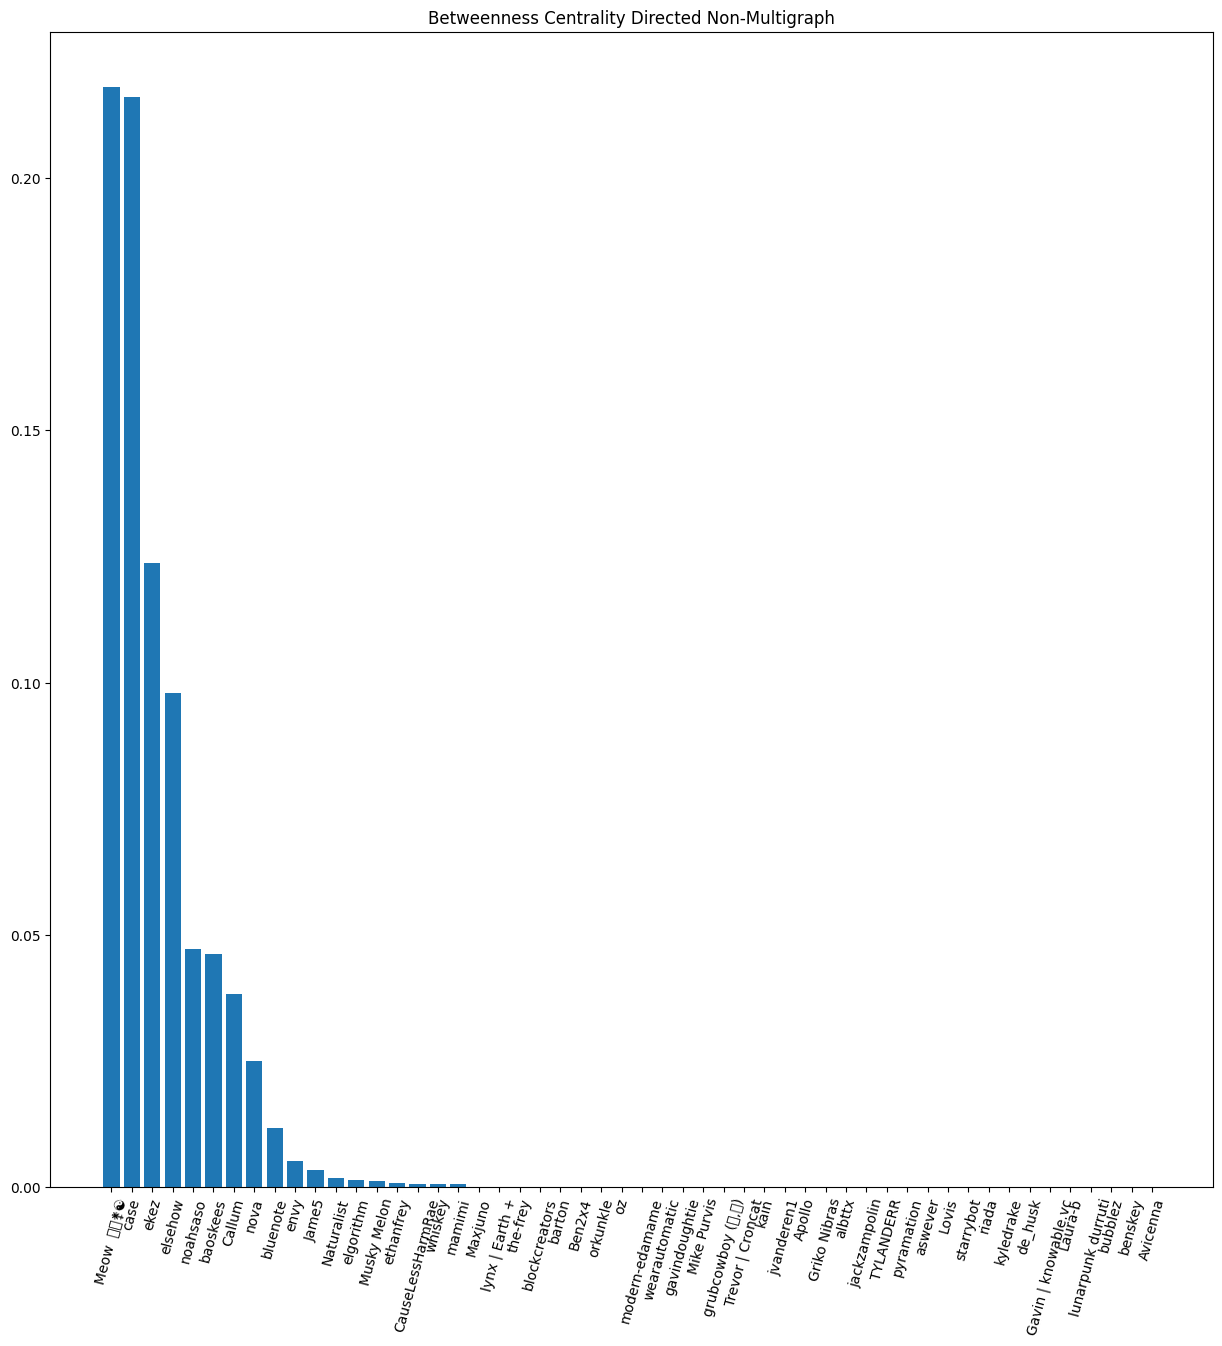

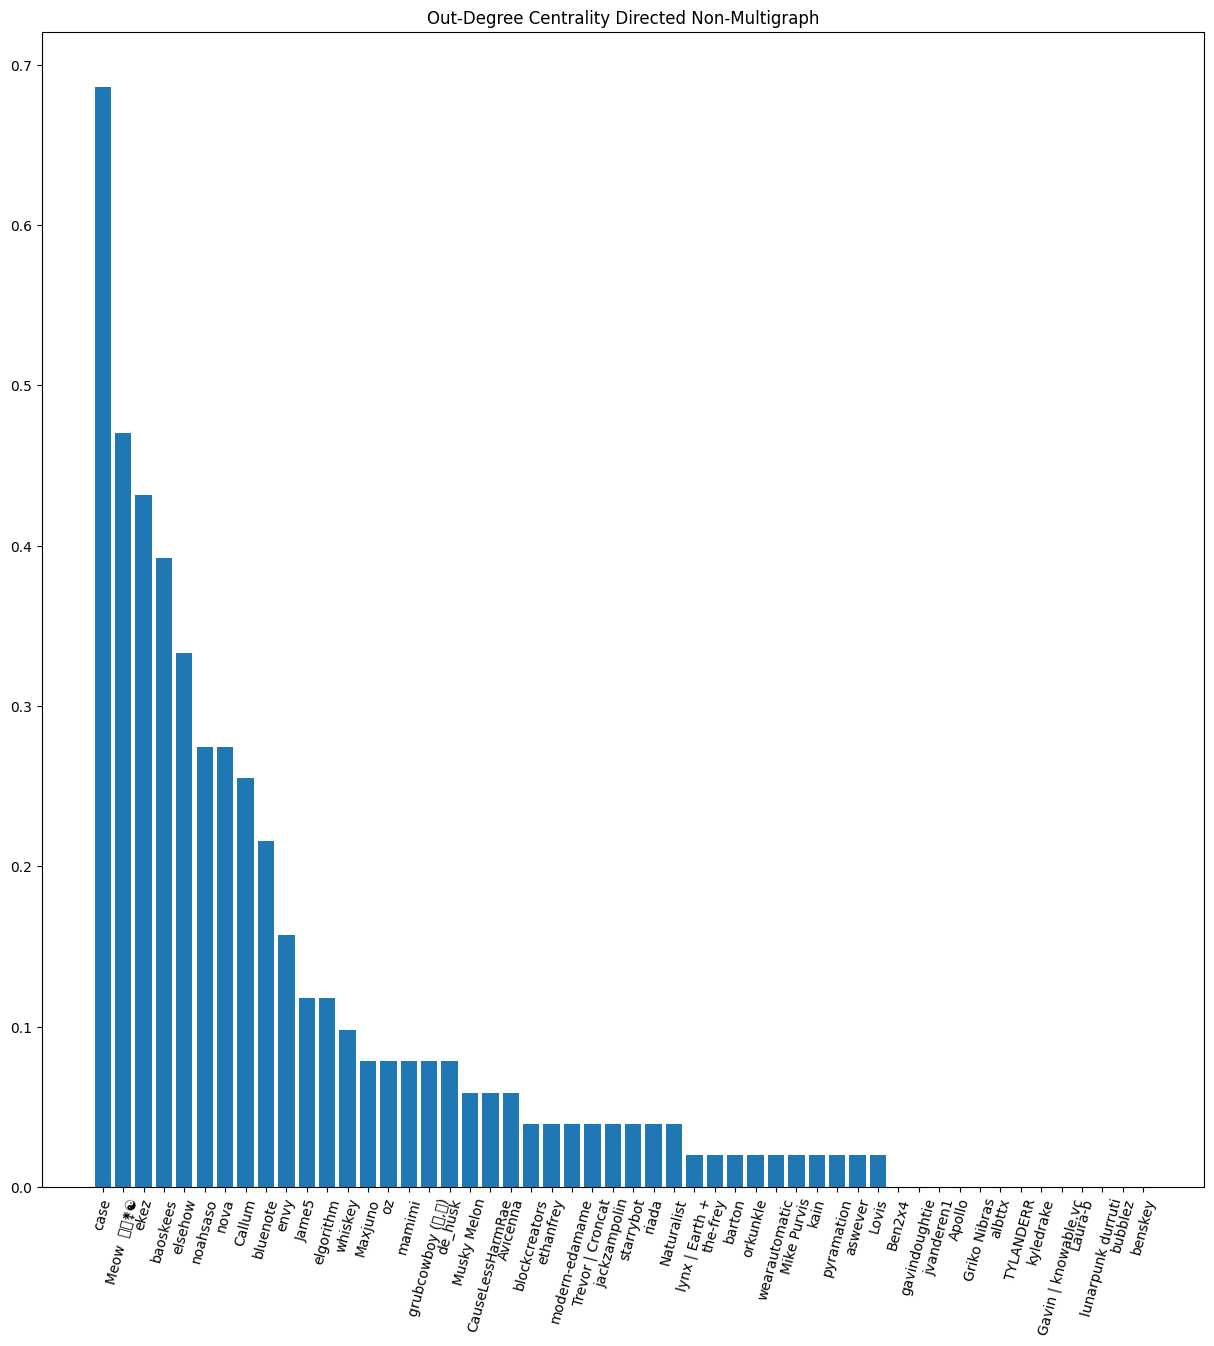

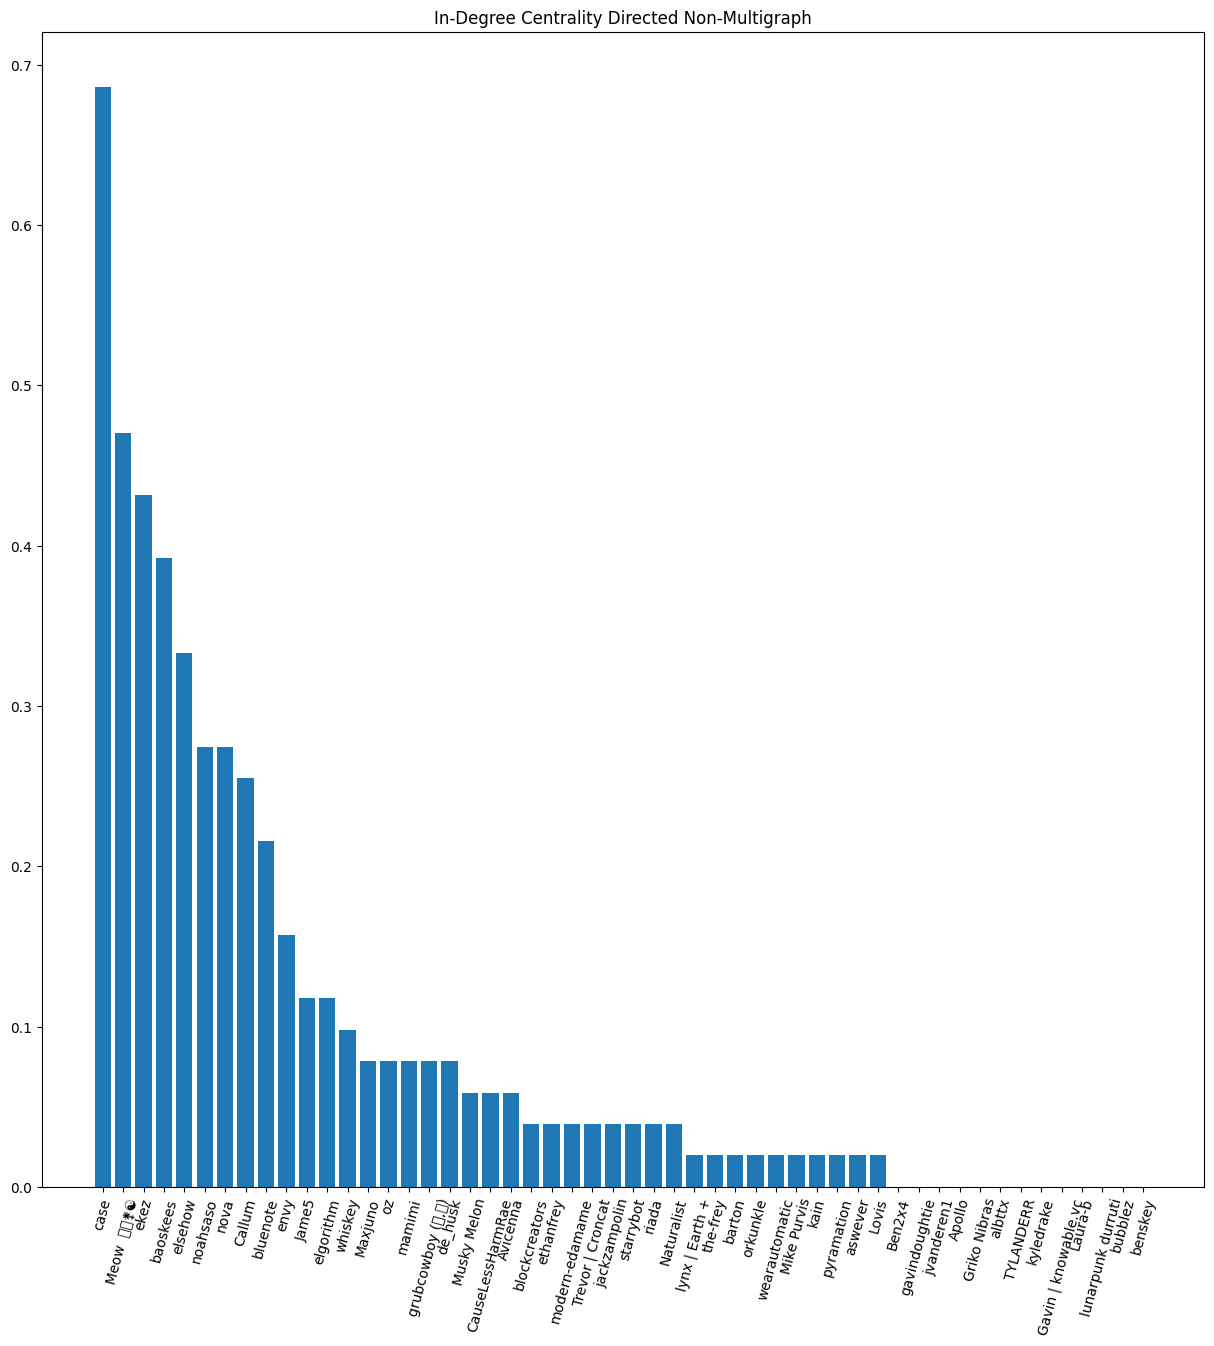

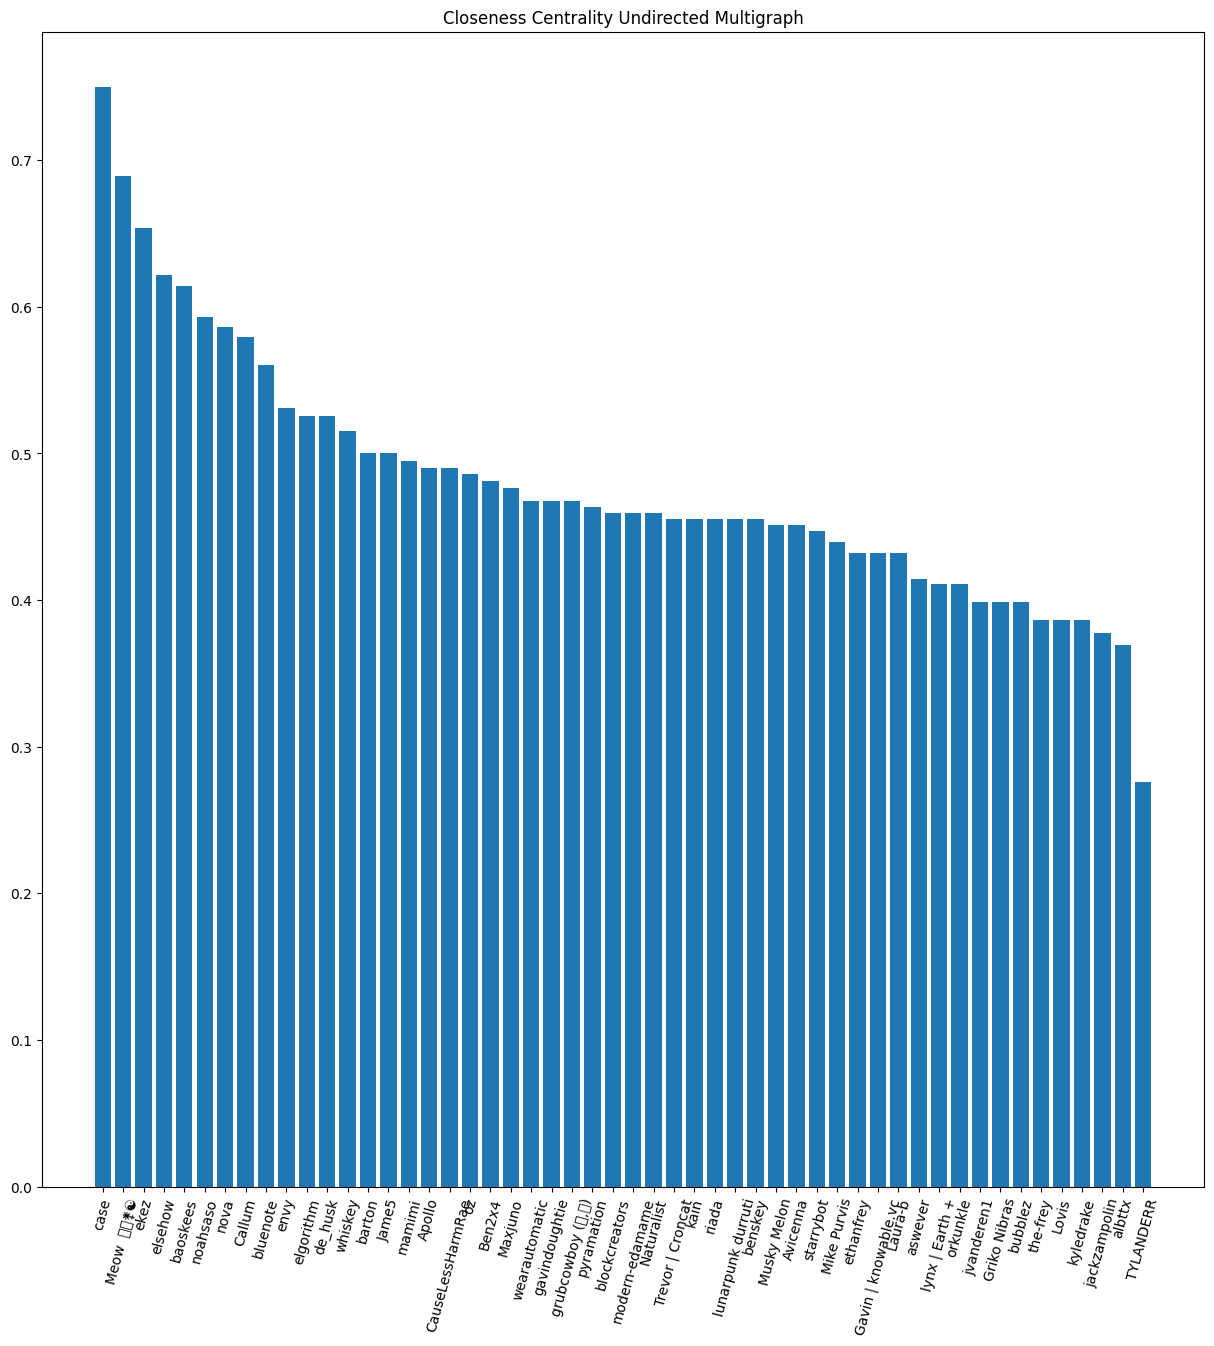

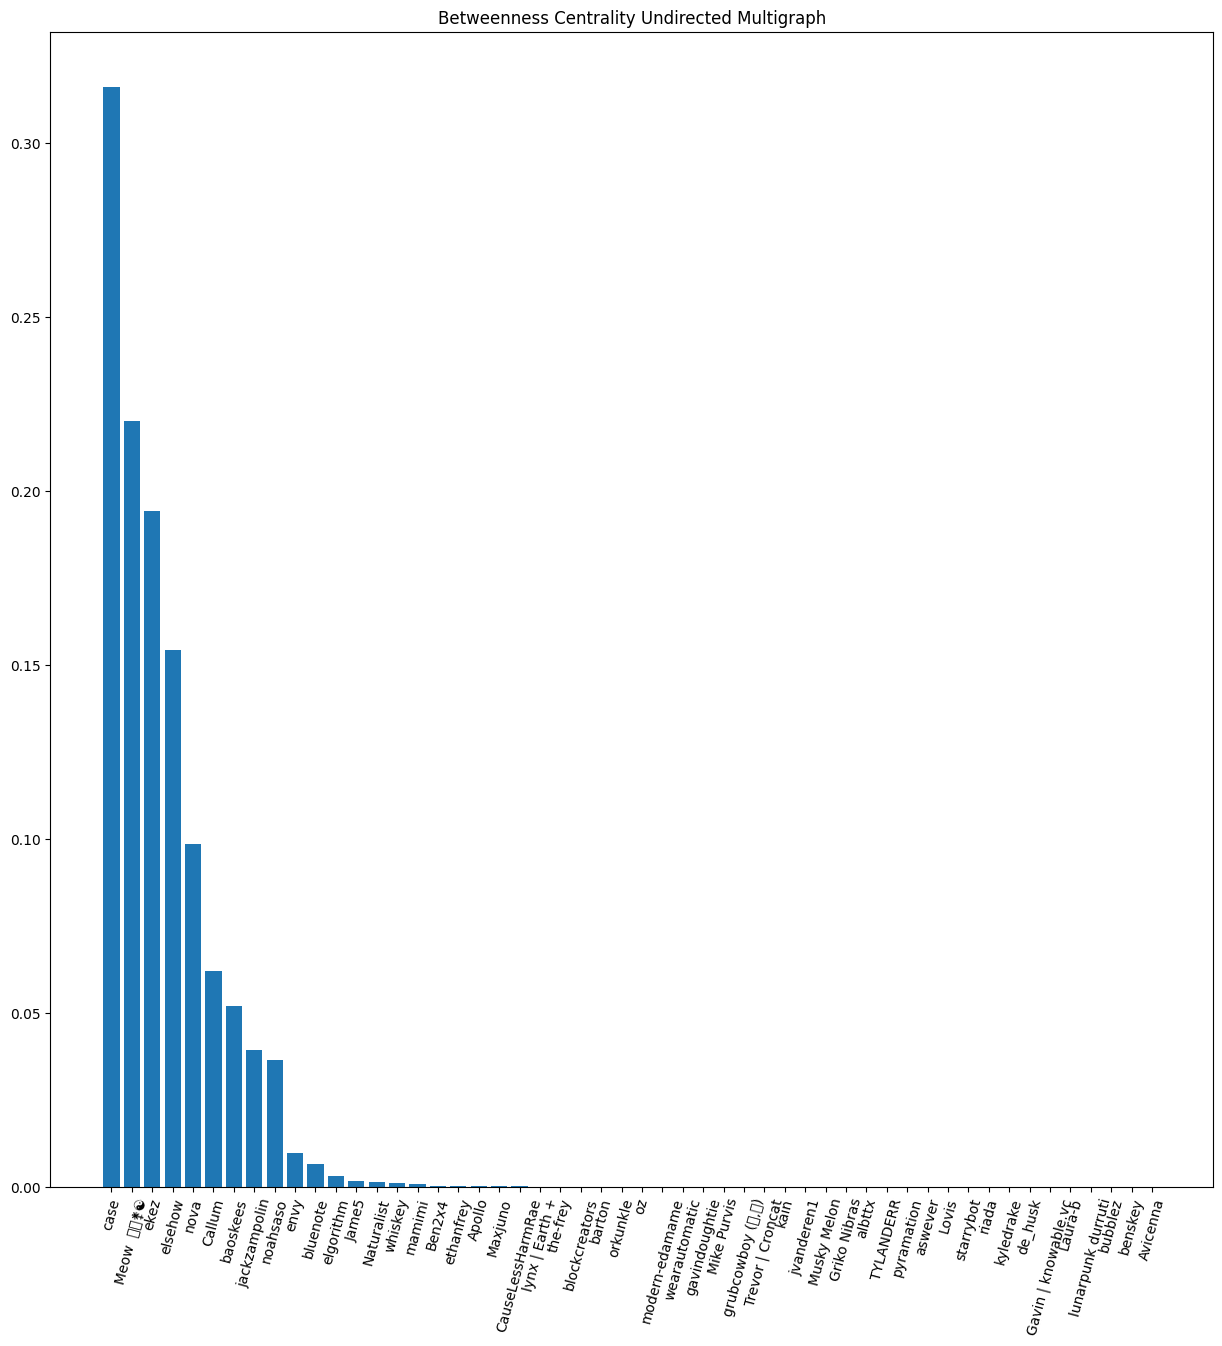

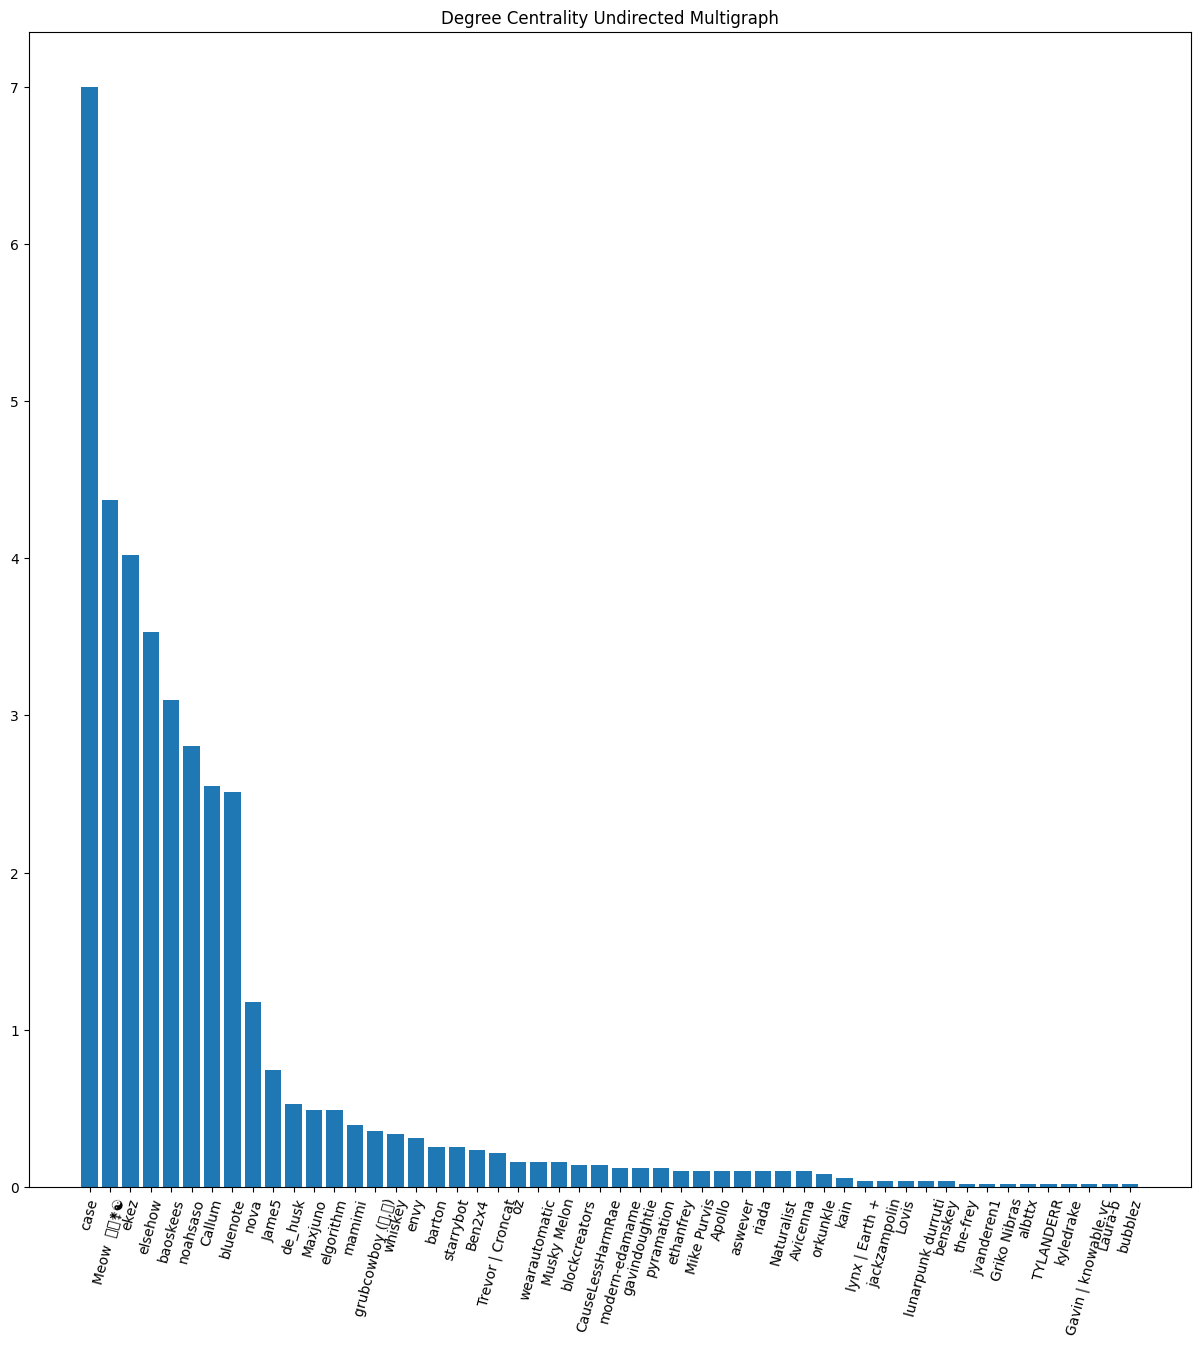

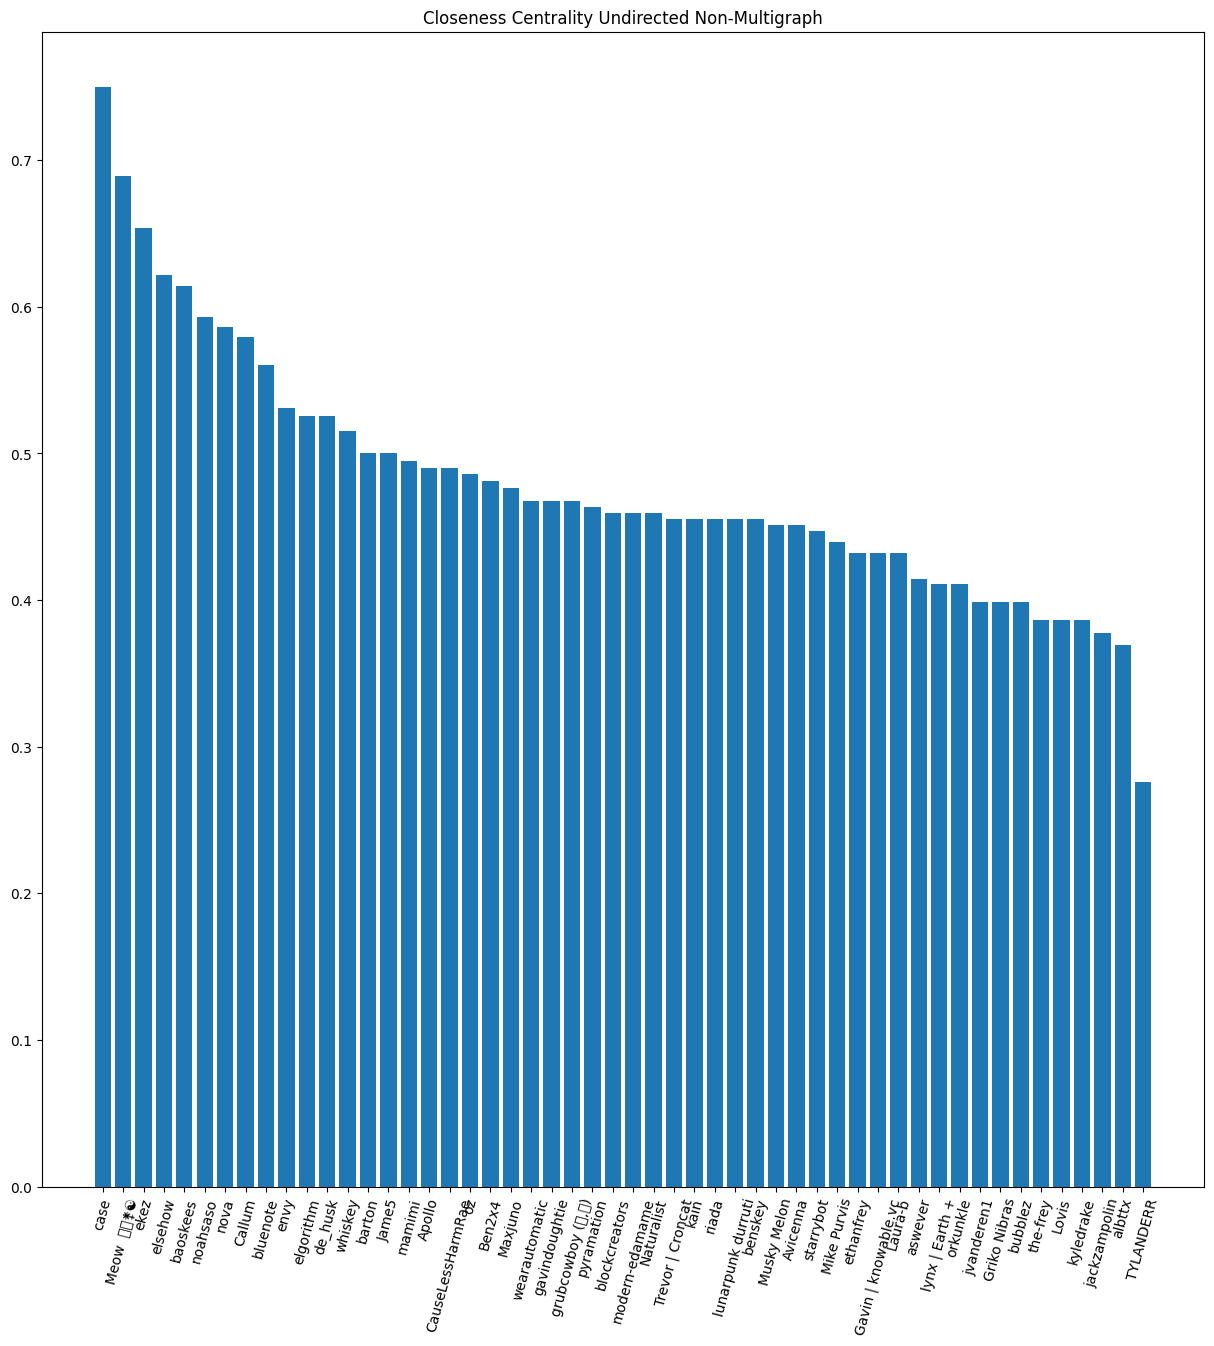

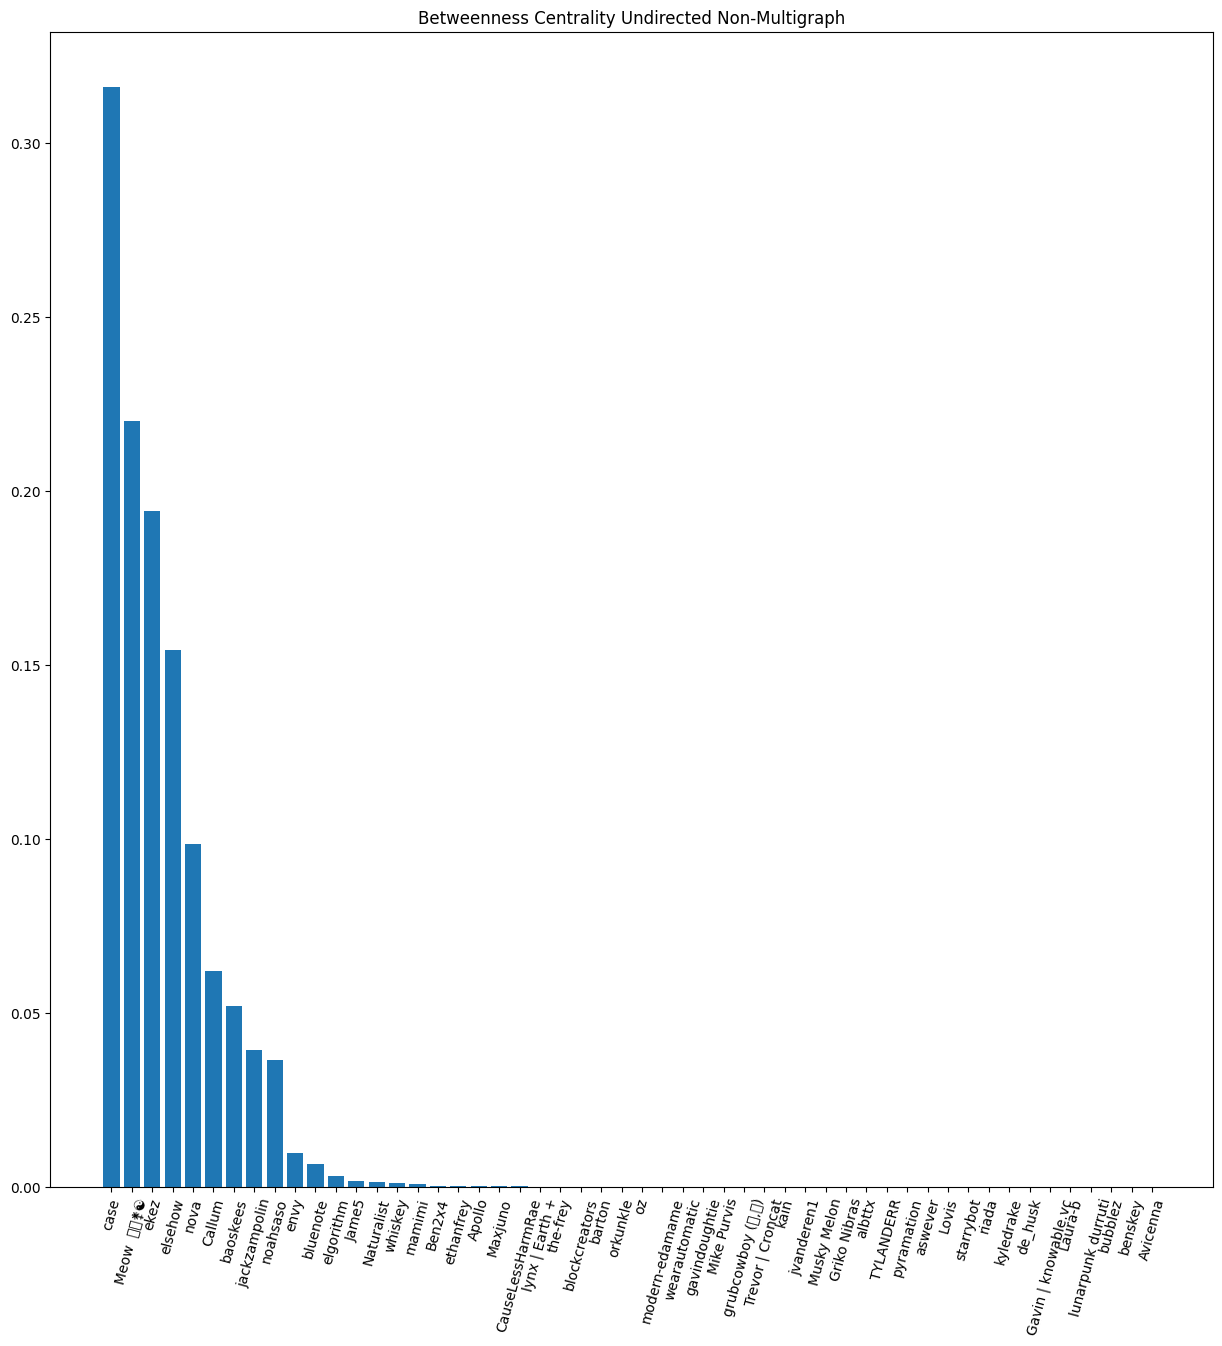

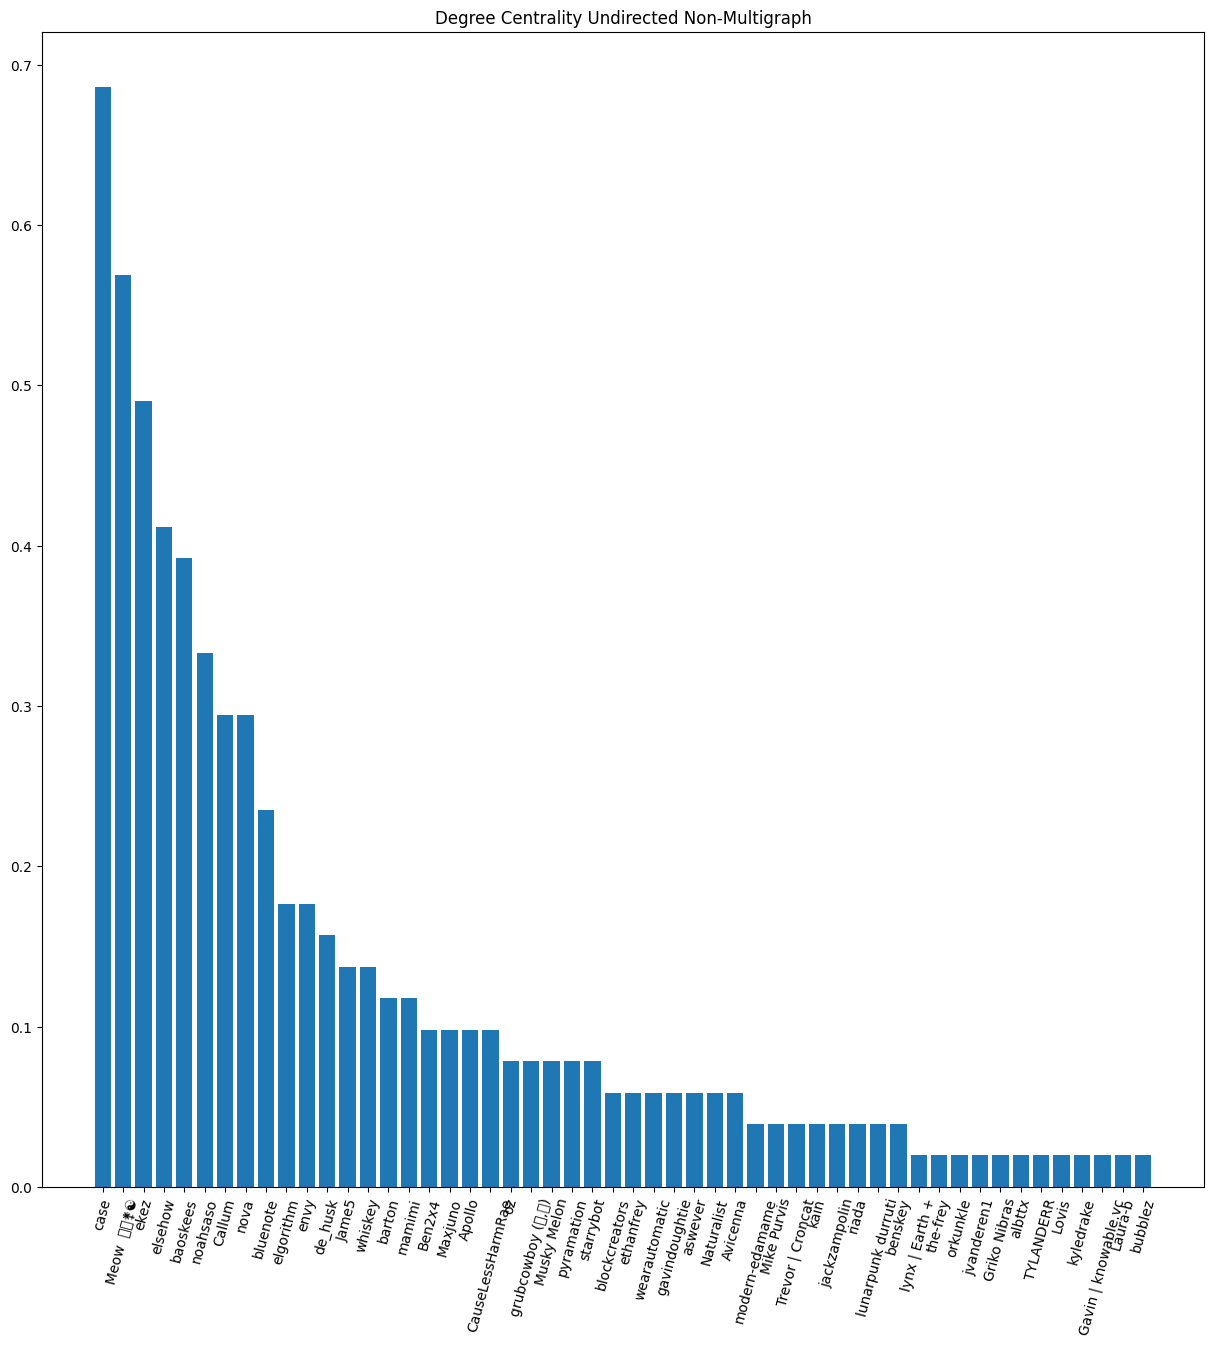

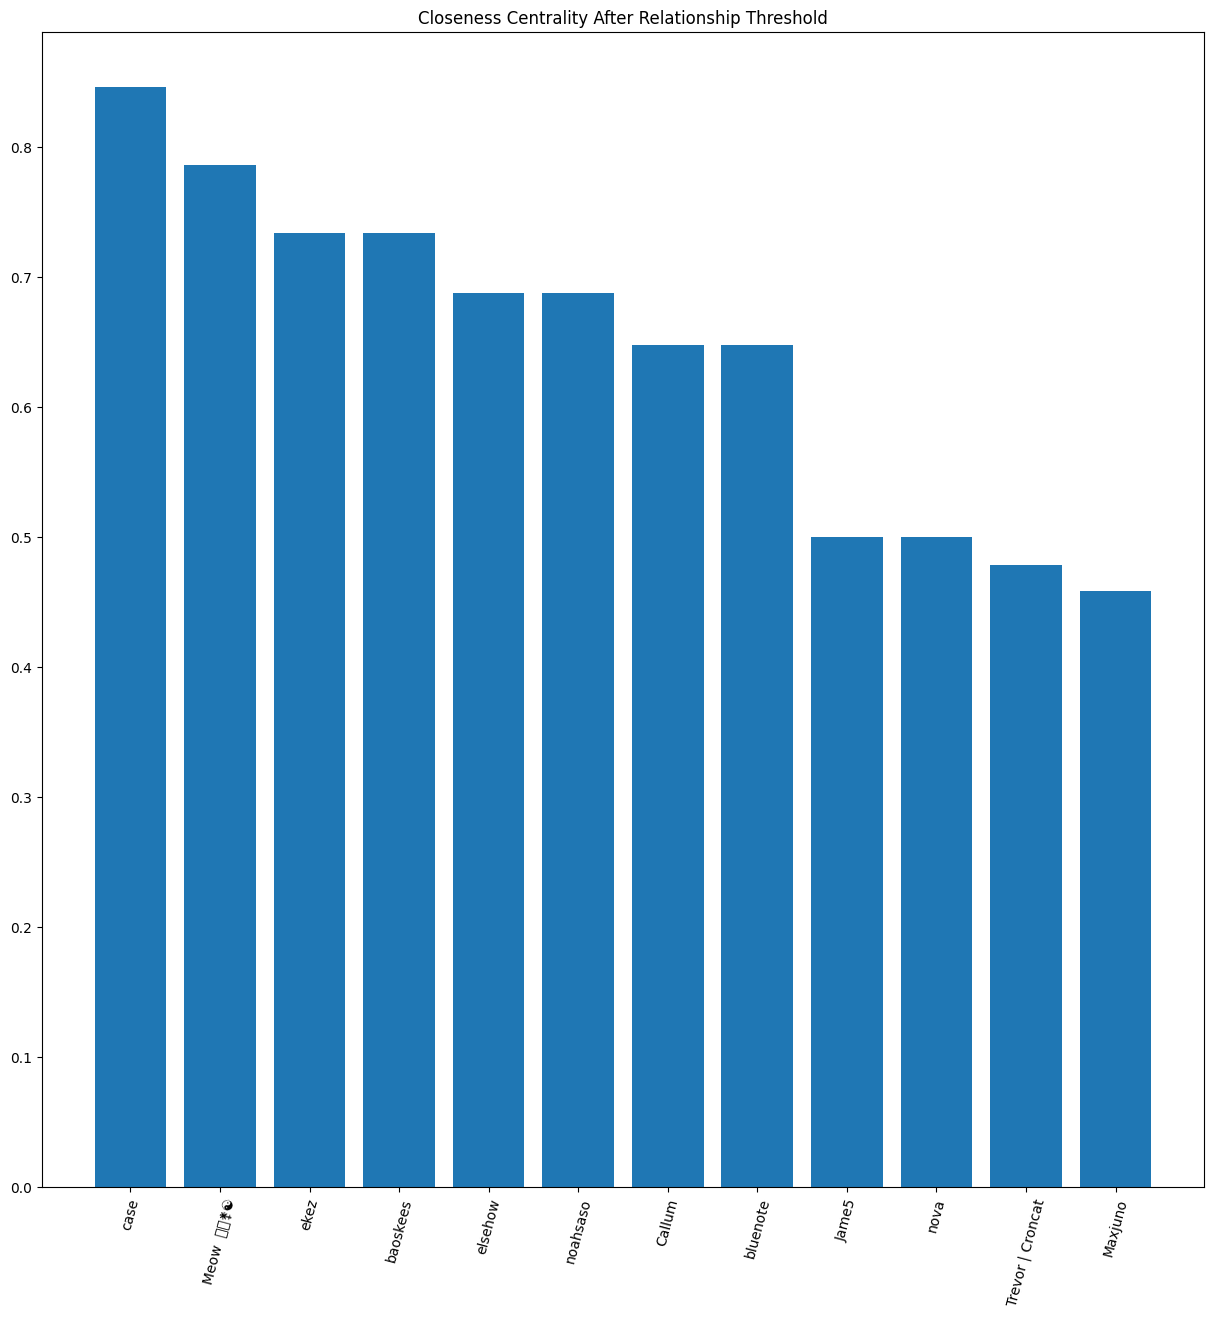

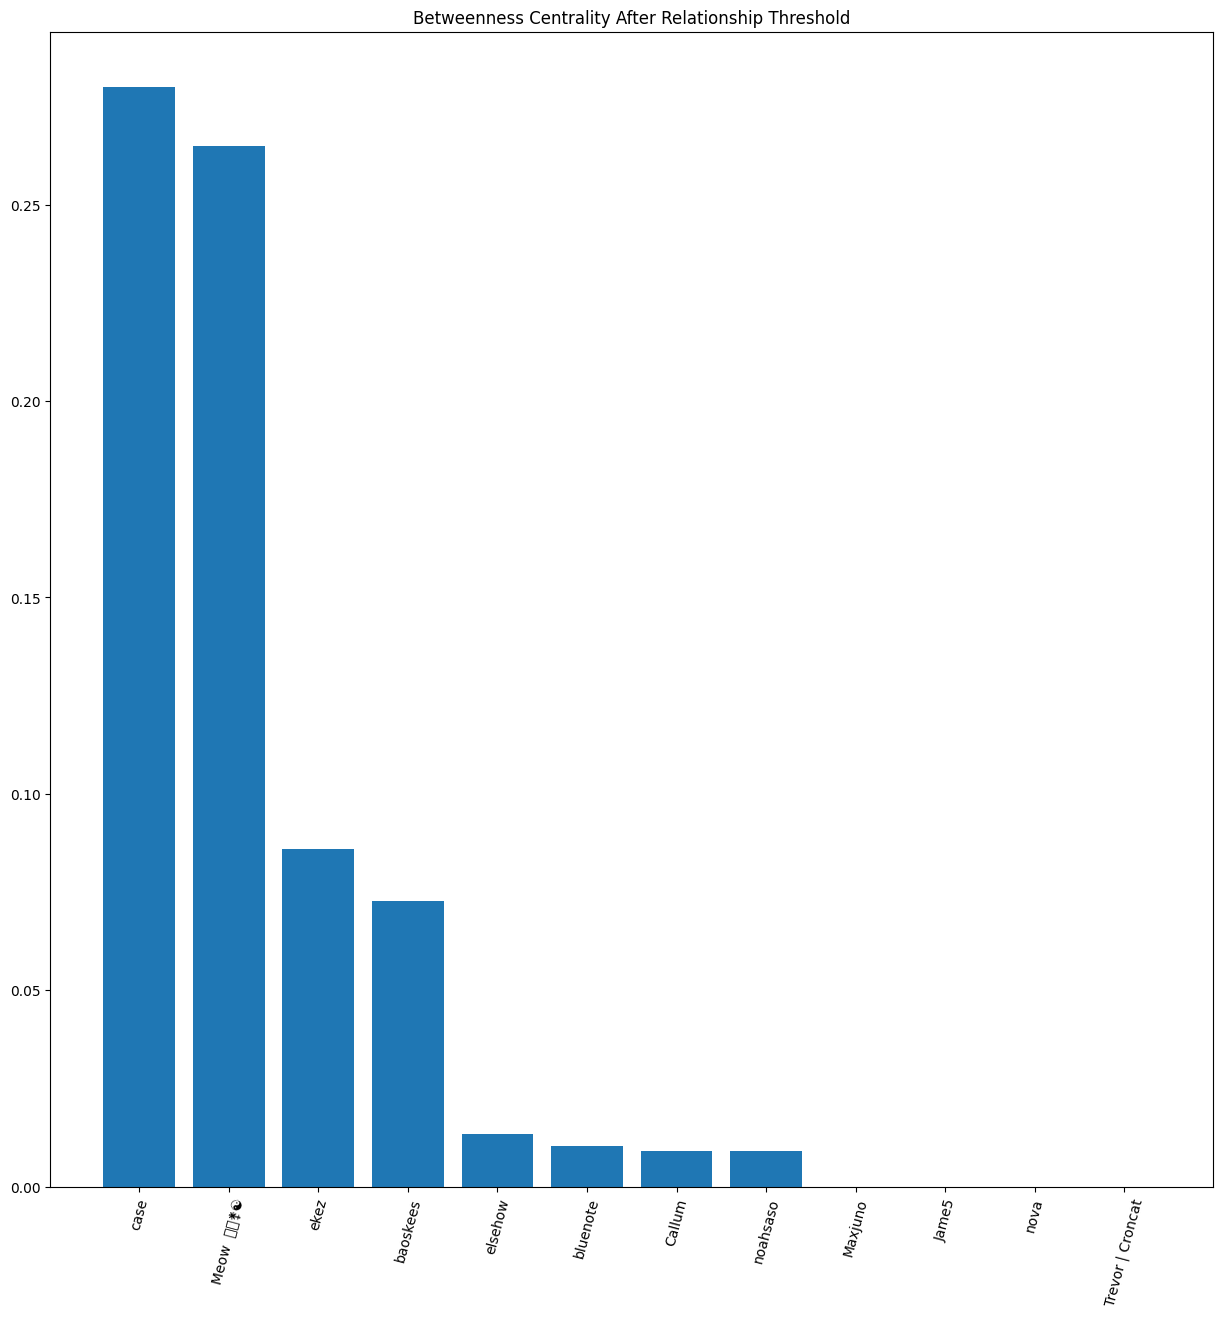

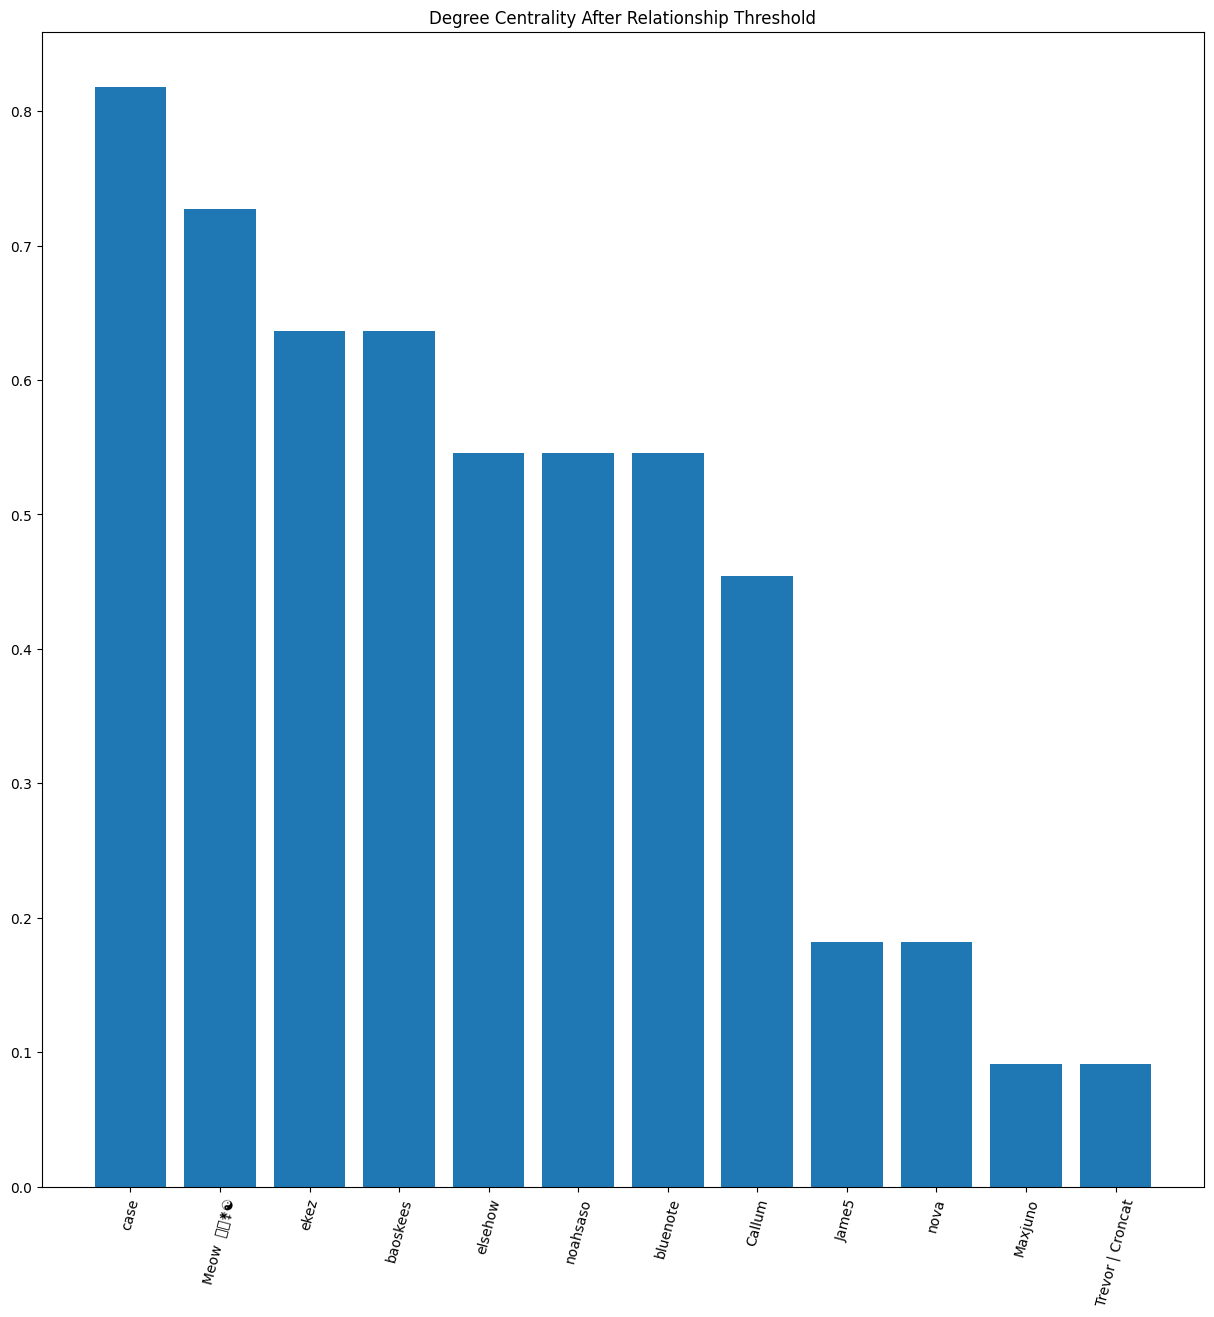

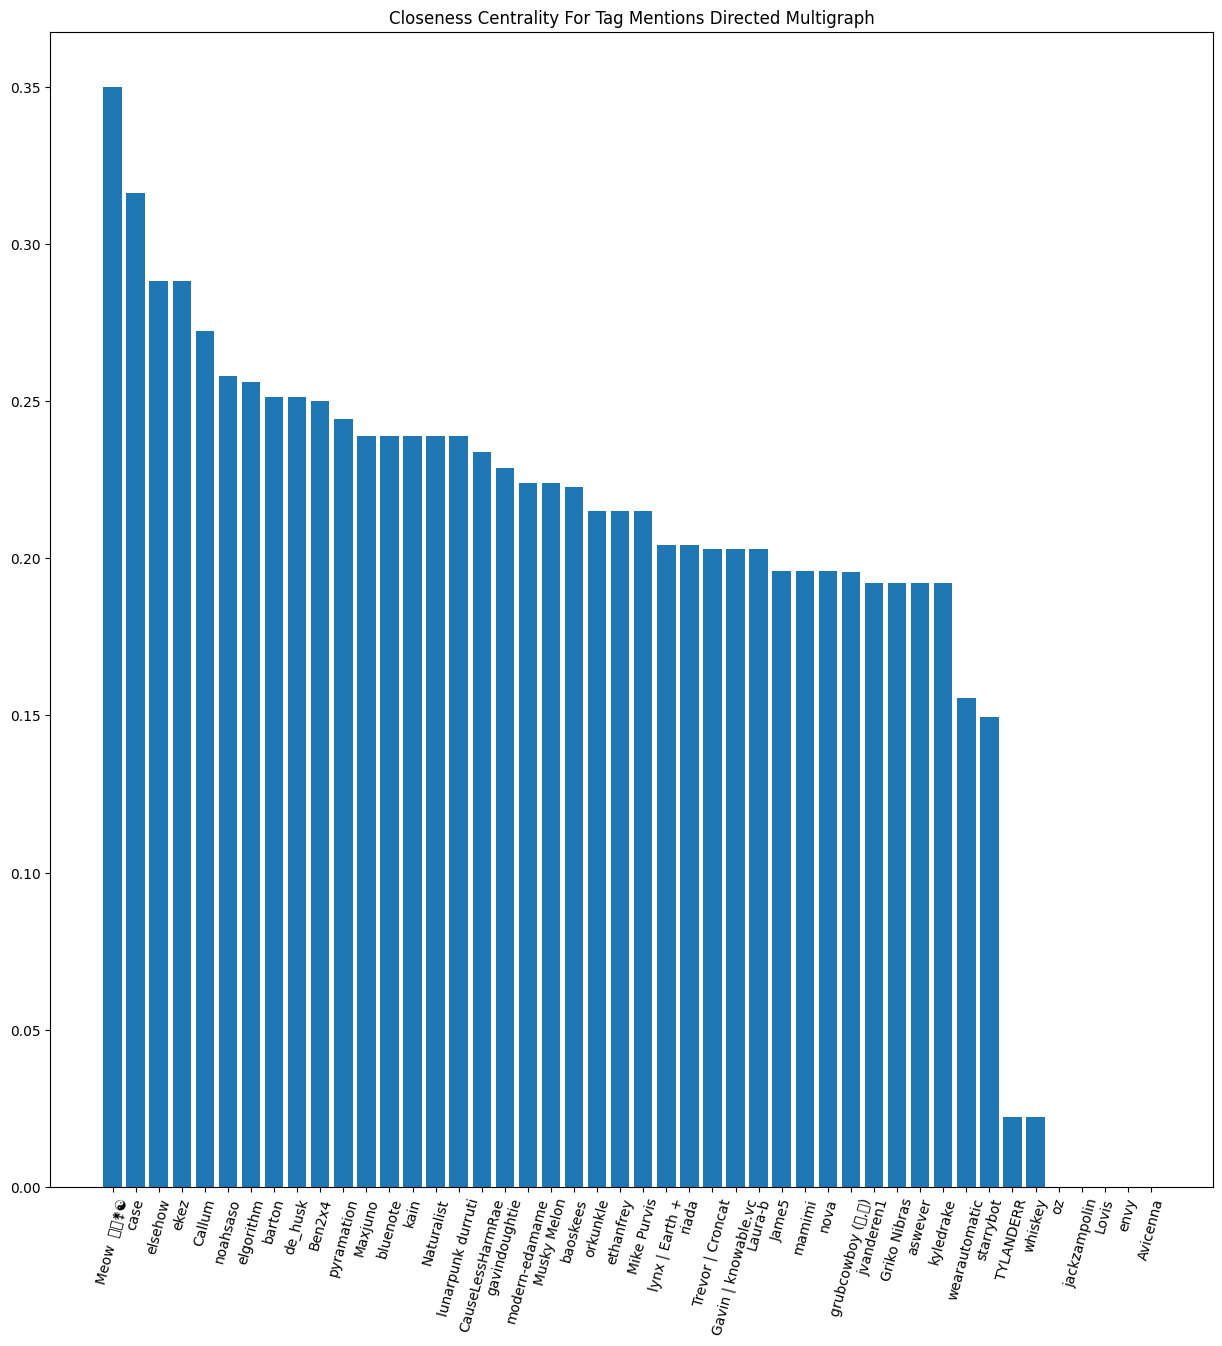

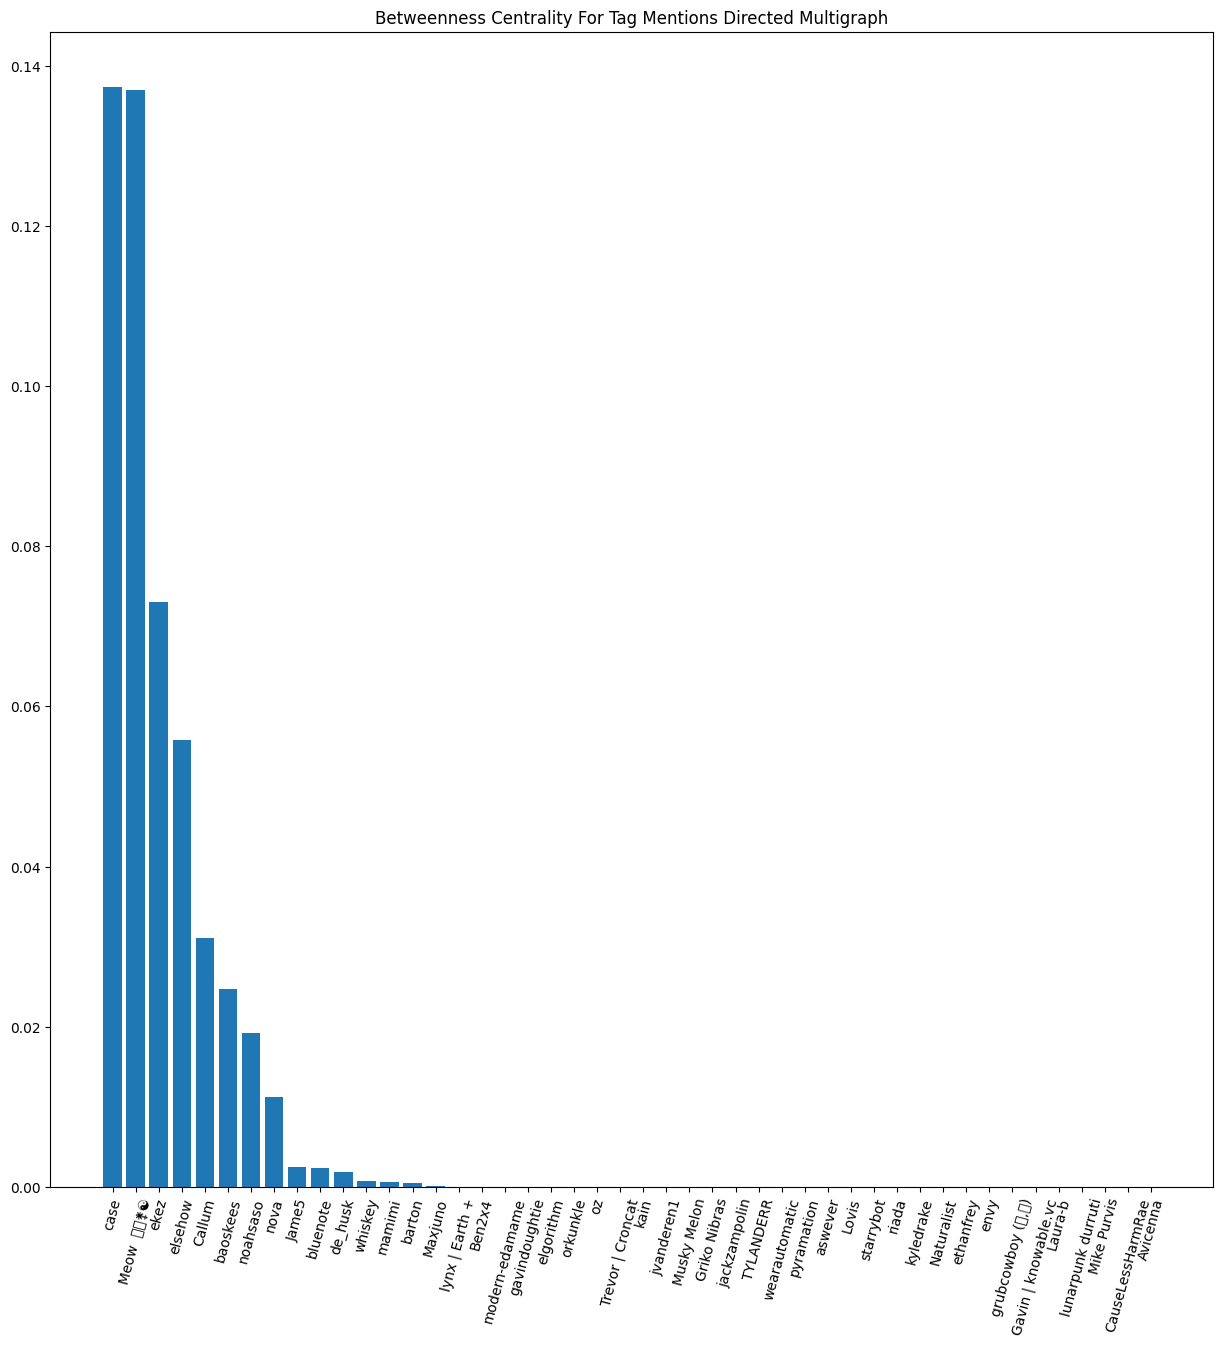

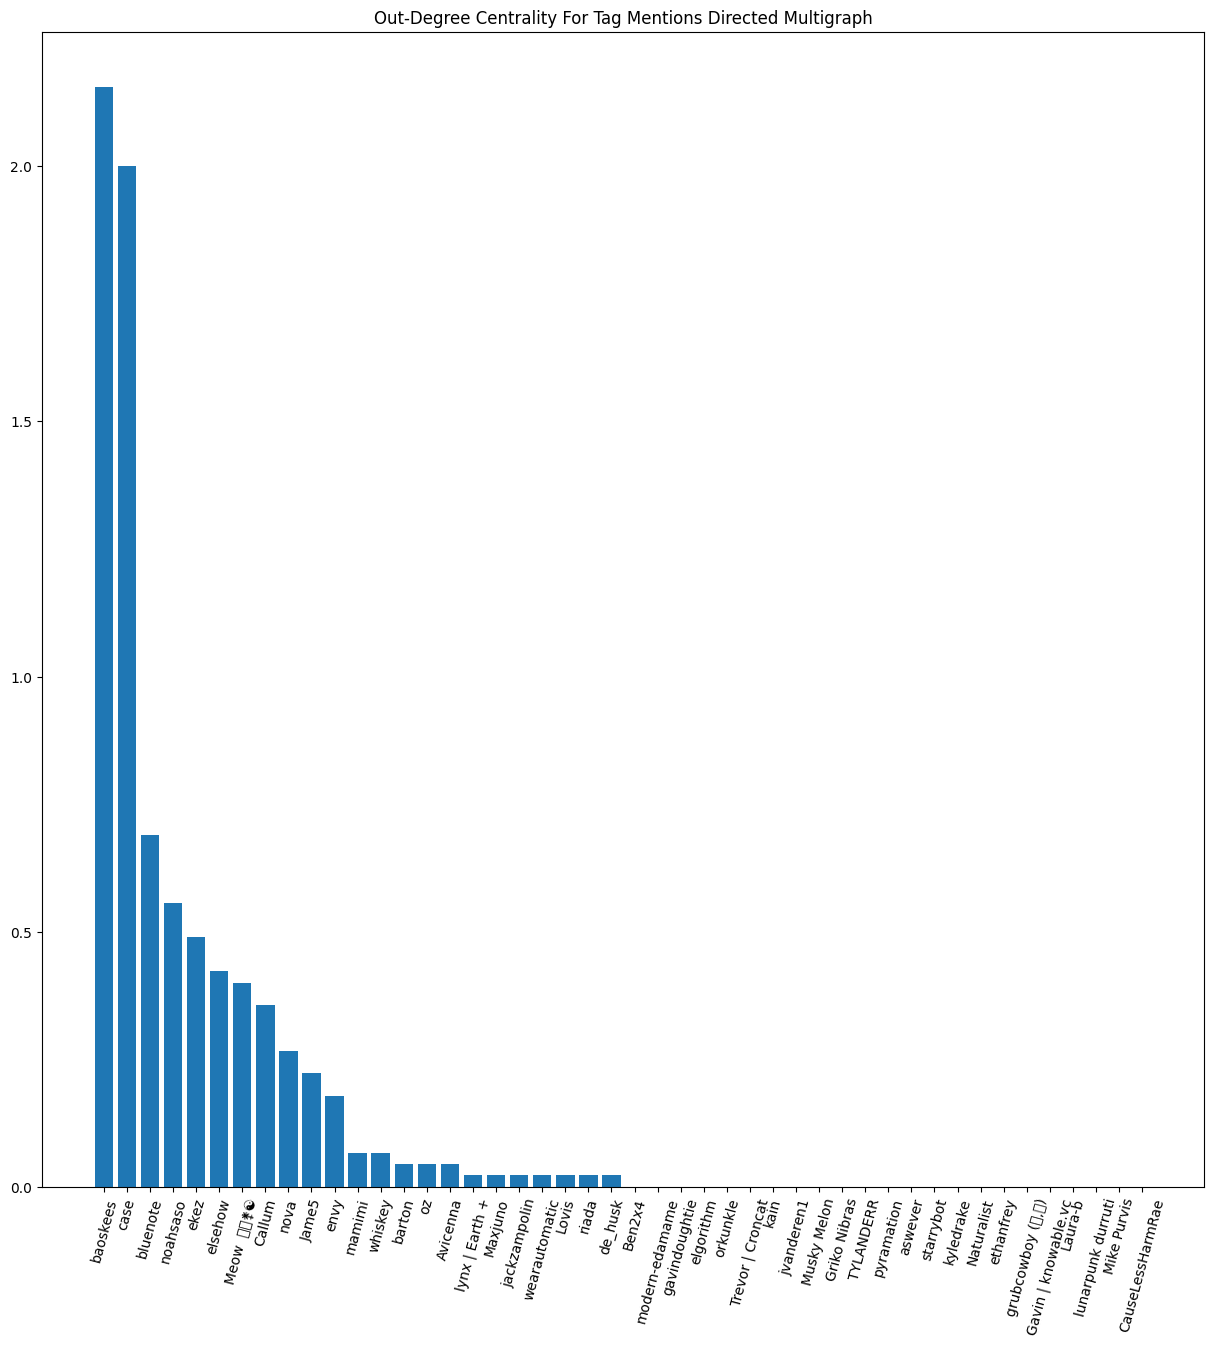

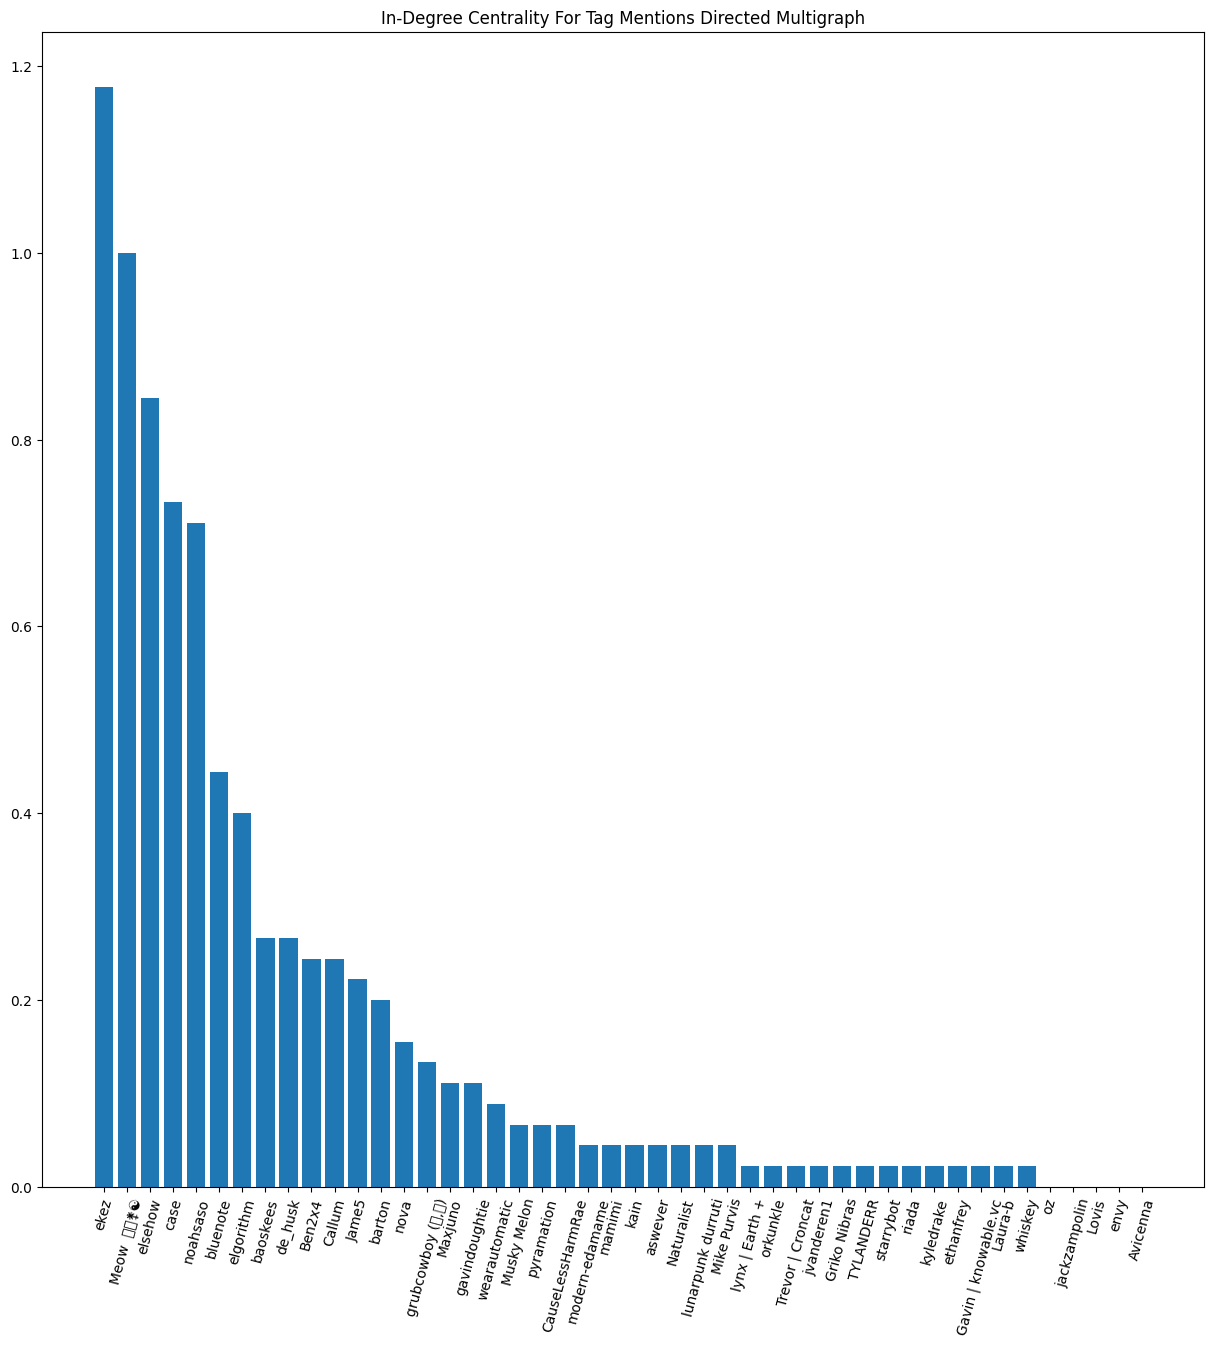

In [21]:
import json
import os
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
from pyvis.network import Network

WEIGHT_NORMALIZATION_FACTOR=10
RELATIONSHIP_MESSAGE_THRESHOLD=10 # how many reply messages have been exchanged before a 'relationship' is considered to have been established

def default():
    return 0

def generate_weighted_graph_undirected(edge_weights):
  graph = nx.Graph()
  net = Network(notebook=True, height='1000px', cdn_resources='remote')
  for pair, weight in edge_weights.items():
    graph.add_edges_from([(pair[0], pair[1], {'weight': weight / WEIGHT_NORMALIZATION_FACTOR})])

  render_graph(graph, "weighted-graph.html")

def generate_bar_graph_from_dict_barh(d, title):
    xAxis = list(d.keys())
    yAxis = list(d.values())
    f = plt.figure()
    plt.rcParams["figure.autolayout"] = True
    f.set_figwidth(15)
    f.set_figheight(10)
    plt.barh(xAxis, yAxis)
    plt.title(title)
    plt.xlabel('Score', fontsize=10)
    plt.ylabel('Actor', fontsize=10)
#     plt.show()
    plt.savefig(f'./images/{title}')
    
def generate_bar_graph_from_dict(d, title):
    sorted_dict = sorted(d.items(), key=lambda item: item[1], reverse=True)
    sorted_keys_and_values = list(map(list, zip(*sorted_dict)))
    xAxis = sorted_keys_and_values[0]
    yAxis = sorted_keys_and_values[1]
    f = plt.figure()
    f.set_figwidth(15)
    f.set_figheight(15)
    plt.bar(xAxis, yAxis)
    plt.title(title)
#     plt.xlabel('Actor', fontsize=10)
#     plt.ylabel('Score', fontsize=10)
    plt.xticks(rotation = 75) 
#     plt.show()
    plt.savefig(f'./images/{title}')

def compute_closeness_centrality(graph):
  closeness = nx.closeness_centrality(graph)
  return closeness
    
def compute_betweenness_centrality(graph):
  betweenness = nx.betweenness_centrality(graph)
  return betweenness

def compute_degree_centrality(graph):
  degree = nx.degree_centrality(graph)
  return degree

def compute_in_degree_centrality(graph):
  degree = nx.in_degree_centrality(graph)
  return degree

def compute_out_degree_centrality(graph):
  degree = nx.out_degree_centrality(graph)
  return degree
    
def compute_eigenvector_centrality(edge_weights):
  graph = nx.Graph()
  net = Network(notebook=True, height='1000px', cdn_resources='remote', directed=True)
  for pair, weight in edge_weights.items():
    graph.add_edges_from([(pair[0], pair[1]), {'weight': weight}])
  eigen = nx.eigenvector_centrality(graph)
  print('\n***************SORTED EIGENVECTOR CENTRALITY***************\n')
  for key, value in sorted(eigen.items(), key=lambda item: item[1], reverse=True):
    print(key, ' : ', value)
    
def render_graph(graph, name, directed=False):
  net = Network(notebook=True, height='1000px', cdn_resources='remote', directed=directed)
  net.from_nx(graph)
  net.toggle_physics(True)
#   net.show_buttons(filter_=['physics'])
  net.set_options("""
  const options = {
  "physics": {
    "barnesHut": {
      "gravitationalConstant": -24800
    },
    "minVelocity": 0.75
  }
}
""")
  net.show(name)

def parse_channels_into_edges():
  # this records direction of communication (first member of the tuple is the initiator of message, second is the receiver)
  directed_edge_weights = defaultdict(default)
  # this does not record direction of communication (an edge weight just represents number of messages)
  undirected_edge_weights = defaultdict(default)
  # this only captures the tag (ie '@' mentions)
  tag_mention_directed_edge_weights = defaultdict(default)

  channels_dir = 'channels_json'
  for channel in os.listdir(channels_dir):
    file = os.path.join(channels_dir, channel)
    with open(file, 'r') as f:
      messages = json.load(f)
      for entry in messages['messages']: 
        author = entry['author']['name']
        # Record mentions
        mentions = entry['mentions']
        message_type = entry['type']
        if len(mentions) > 0:
            for mention in mentions:
                mentionee = mention['name']
                pair = (author, mentionee)
                directed_edge_weights[pair] += 1
                sorted_pair = sorted(pair, key=str.casefold)
                undirected_edge_weights[tuple(sorted_pair)] += 1
                # record tag mention if so (ie, message type is not 'reply')
                if message_type == 'Default':
                    tag_mention_directed_edge_weights[pair] += 1

    return directed_edge_weights, undirected_edge_weights, tag_mention_directed_edge_weights

def print_reverse_sorted_dict(d):
    for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True):
      print(k, ' : ', v)
    
def main():
    directed_edge_weights, undirected_edge_weights, tag_mention_directed_edge_weights = parse_channels_into_edges()
    
    # generate graph with weighted edges
    generate_weighted_graph_undirected(undirected_edge_weights)
    
    # create a directed multigraph
    graph = nx.MultiDiGraph()
    for pair, weight in directed_edge_weights.items():
        for i in range(weight): # add as many edges as there is weight between these two nodes (weight = # of replies)
            graph.add_edge(pair[0], pair[1])

    render_graph(graph, "./network_graphs/multi-digraph.html", True)
    closeness = compute_closeness_centrality(graph)
    betweenness = compute_betweenness_centrality(graph)
    out_degree = compute_out_degree_centrality(graph)
    in_degree = compute_in_degree_centrality(graph)
    generate_bar_graph_from_dict(closeness, 'Closeness Centrality Directed Multigraph')
    generate_bar_graph_from_dict(betweenness, 'Betweenness Centrality Directed Multigraph')
    generate_bar_graph_from_dict(out_degree, 'Out-Degree Centrality Directed Multigraph')
    generate_bar_graph_from_dict(out_degree, 'In-Degree Centrality Directed Multigraph')
    
    # create a directed non-multigraph 
    graph = nx.DiGraph()
    for pair, weight in directed_edge_weights.items():
        graph.add_edge(pair[0], pair[1])
    
    render_graph(graph, "./network_graphs/digraph.html", True)
    closeness = compute_closeness_centrality(graph)
    betweenness = compute_betweenness_centrality(graph)
    out_degree = compute_out_degree_centrality(graph)
    in_degree = compute_in_degree_centrality(graph)
    generate_bar_graph_from_dict(closeness, 'Closeness Centrality Directed Non-Multigraph')
    generate_bar_graph_from_dict(betweenness, 'Betweenness Centrality Directed Non-Multigraph')
    generate_bar_graph_from_dict(out_degree, 'Out-Degree Centrality Directed Non-Multigraph')
    generate_bar_graph_from_dict(out_degree, 'In-Degree Centrality Directed Non-Multigraph')

    
    # create an undirected multigraph
    graph = nx.MultiGraph()
    for pair, weight in undirected_edge_weights.items():
        for i in range(weight): # add as many edges as there is weight between these two nodes (weight = # of reply or tag mentions)
            graph.add_edge(pair[0], pair[1])
    
    render_graph(graph, "./network_graphs/multigraph.html")
    closeness = compute_closeness_centrality(graph)
    betweenness = compute_betweenness_centrality(graph)
    degree = compute_degree_centrality(graph)
    generate_bar_graph_from_dict(closeness, 'Closeness Centrality Undirected Multigraph')
    generate_bar_graph_from_dict(betweenness, 'Betweenness Centrality Undirected Multigraph')
    generate_bar_graph_from_dict(degree, 'Degree Centrality Undirected Multigraph')

    # create an undirected non-multigraph
    graph = nx.Graph()
    for pair, weight in undirected_edge_weights.items():
        graph.add_edge(pair[0], pair[1])
    
    render_graph(graph, "./network_graphs/graph.html")
    closeness = compute_closeness_centrality(graph)
    betweenness = compute_betweenness_centrality(graph)
    degree = compute_degree_centrality(graph)
    generate_bar_graph_from_dict(closeness, 'Closeness Centrality Undirected Non-Multigraph')
    generate_bar_graph_from_dict(betweenness, 'Betweenness Centrality Undirected Non-Multigraph')
    generate_bar_graph_from_dict(degree, 'Degree Centrality Undirected Non-Multigraph')
    
    # create a relationship-threshold-edge undirected non-multigraph 
    graph = nx.Graph()
    for pair, weight in undirected_edge_weights.items():
        if weight >= RELATIONSHIP_MESSAGE_THRESHOLD:
            graph.add_edge(pair[0], pair[1])
            
    render_graph(graph, "./network_graphs/graph-relationships.html")
    closeness = compute_closeness_centrality(graph)
    betweenness = compute_betweenness_centrality(graph)
    degree = compute_degree_centrality(graph)
    generate_bar_graph_from_dict(closeness, 'Closeness Centrality After Relationship Threshold')
    generate_bar_graph_from_dict(betweenness, 'Betweenness Centrality After Relationship Threshold')
    generate_bar_graph_from_dict(degree, 'Degree Centrality After Relationship Threshold')
    
    # create a tag-mention-edge directed multigraph
    graph = nx.MultiDiGraph()
    for pair, weight in tag_mention_directed_edge_weights.items():
        for i in range(weight): # add as many edges as there is weight between these two nodes (weight = # of tags)
            graph.add_edge(pair[0], pair[1])

    render_graph(graph, "./network_graphs/tag-mention-multi-digraph.html", True)
    closeness = compute_closeness_centrality(graph)
    betweenness = compute_betweenness_centrality(graph)
    out_degree = compute_out_degree_centrality(graph)
    in_degree = compute_in_degree_centrality(graph)
    generate_bar_graph_from_dict(closeness, 'Closeness Centrality For Tag Mentions Directed Multigraph')
    generate_bar_graph_from_dict(betweenness, 'Betweenness Centrality For Tag Mentions Directed Multigraph')
    generate_bar_graph_from_dict(out_degree, 'Out-Degree Centrality For Tag Mentions Directed Multigraph')
    generate_bar_graph_from_dict(in_degree, 'In-Degree Centrality For Tag Mentions Directed Multigraph')

    
if __name__ == "__main__":
    main()
